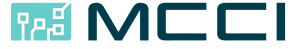

# Current Reuse Amplifier Optimisation

The following script is an design procedure for optimally sizing the differential pair in a current reuse LNA to achieve low input referred thermal noise $\overline{v_{n,in}}$. Optimum inversion levels are highlighted to achieve minimum thermal spot noise $\overline{v_{n,in}}$. Sizing considerations for the amplifier input capacitance $C_{s}$ (assuming a fixed thermal noise specification) are also considered.

In [1]:
# relevant imports
from pygmid import Lookup as lk
import numpy as np
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(['science', 'ieee'])

# Load Data

At this stage, load the previously characterised PDK data. You can characterise your PDK using [PyGMID](https://github.com/dreoilin/pygmid).

In [2]:
# load data from file
NCH = lk('65n12tox.mat')
PCH = lk('65p12tox.mat')

## Custom Noise Functions

The lookup class contains $\texttt{STH}$ and $\texttt{SFL}$, the thermal noise and flicker noise PSD evaluated at 1 Hz. Both are obtained from DC noise simulation in Spectre. The lookup object functionality can be extended with helper functions to retrieve noise values in a convenient manner.

### Thermal Noise Lookup

$\texttt{STH}$ is reorganised to create a gammma $\gamma$ lookup function:

$$
\frac{\overline{i_d^2}}{\Delta f} = 4k_B T \gamma g_m = \texttt{STH}\\
\gamma = \frac{\texttt{STH_GM}}{4k_B T} 
$$

### Flicker Noise Lookup

The flicker corner can be directly achieved by look up of $\texttt{SFL\_STH}$, the point where flicker and thermal PSDs are equal in magnitude.

$$
f_{co} = \texttt{SFL_STH}
$$

In [3]:
# add custom gamma lookup function
def gamma(self, **kwargs):
    kB = 1.38e-23
    # should provide a GMID, VDS and L
    return self.look_up('STH_GM', **kwargs)/(4*kB*self['TEMP'].item())

def fco(self, **kwargs):
    return self.look_up('SFL_STH', **kwargs) 

lk.gamma = gamma
lk.fco = fco

In [4]:
# Sample usage of gamma function
gamma = NCH.gamma(GM_ID=18, VDS=0.3, L=0.2)
print(gamma)

0.592021259703183


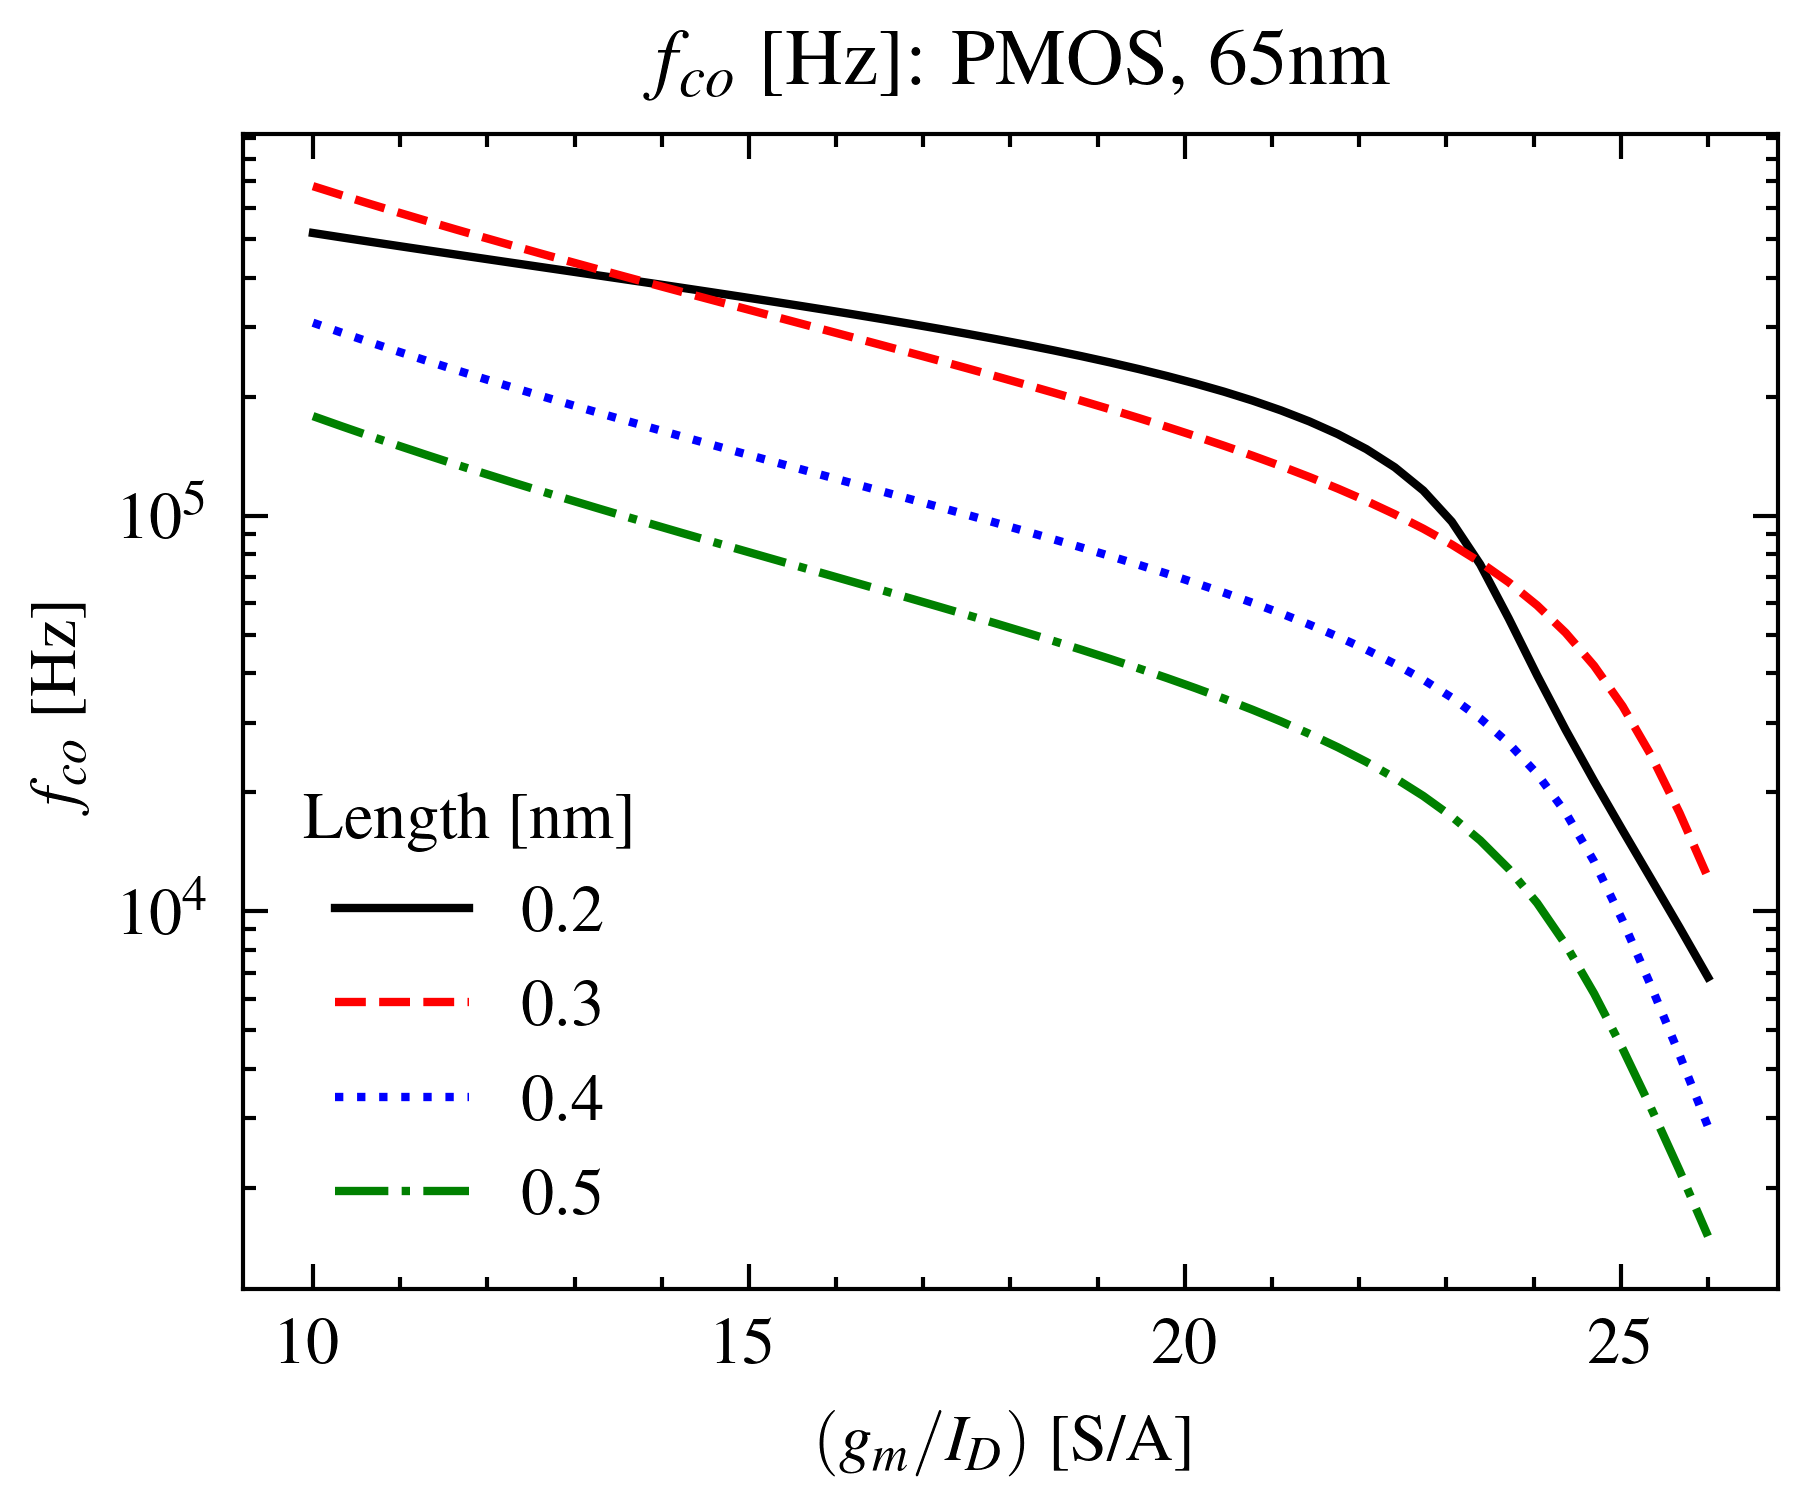

In [5]:
# sample flicker lookup
# sweep some transistor lengths
Ls = [0.2, 0.3, 0.4, 0.5]
GM_IDs = np.linspace(10, 26, num=50)

fcos = PCH.fco(GM_ID=GM_IDs, L=Ls)

plt.title(r"$f_{co}$ [Hz]: PMOS, 65nm")
plt.semilogy(GM_IDs, fcos.T)
plt.ylabel(r"$f_{co}$ [Hz]")
plt.xlabel(r"$(g_m/I_D)$ [S/A]")
plt.legend(Ls, title="Length [nm]")
plt.show()

### Design values

Input design values for the LNA here

In [6]:
# constants
kB = 1.38e-23
# setting temperature to 27 deg C (from gm/ID characterisation)
T = 300.15

# design parameters
G = 20
LN = 0.5
LP = 0.5
Ibias = 20e-6
VDD = 1.2

### Input Referred Noise $\overline{v_{N,in}^2}$

$$
\overline{v_{N,in}^2} = \frac{i_{N,P}^2 + i_{N,N}^2}{\left(g_{m,P} + g_{m,N}\right)^2}\\
\overline{v_{N,in}^2} = \frac{4 k_B T}{\left(g_{m,P} + g_{m,N}\right)^2} \gamma \left( g_{m,P} + g_{m,N} \right)
$$

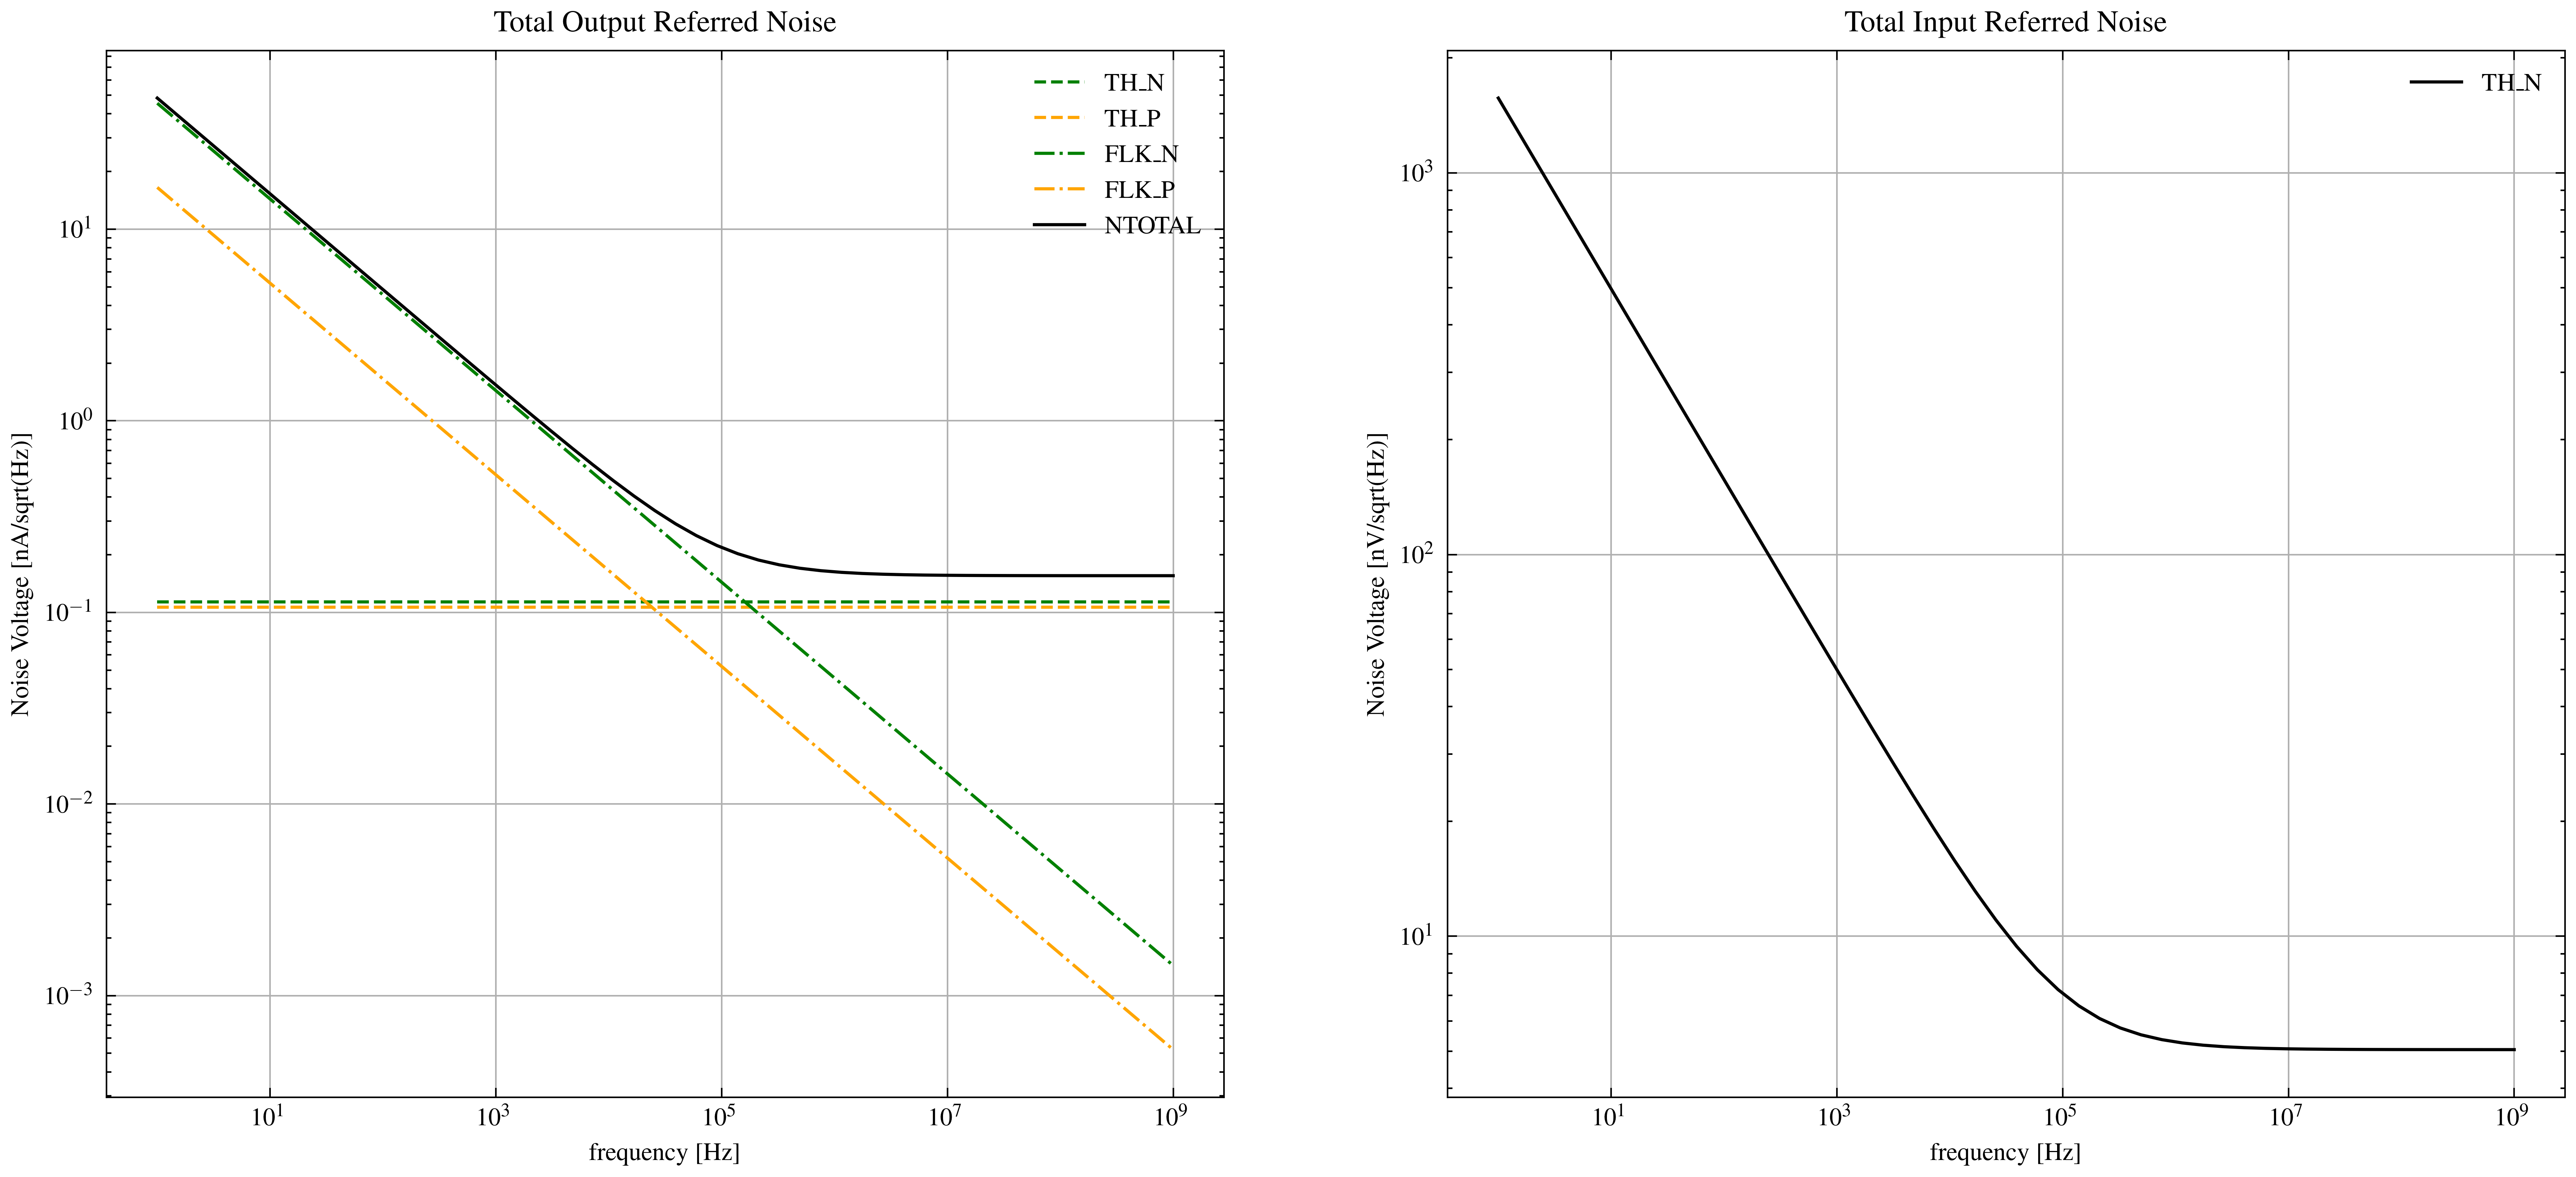

In [26]:
def plot_spectrum(GM_IDN, GM_IDP, LP, LN, Ibias):
    # frequency axis
    fs = np.logspace(0, 9)
    # compute thermal spot noise
    STH_N = 4*kB*T*np.ones(len(fs)) * NCH.gamma(GM_ID=GM_IDN, L=LN, VDS=VDD/4)
    STH_P = 4*kB*T*np.ones(len(fs)) * PCH.gamma(GM_ID=GM_IDP, L=LP, VDS=VDD/4)
    # compute flicker corner
    SFLK_N = STH_N[0]/(fs/NCH.fco(GM_ID=GM_IDN, L=LN, VDS=VDD/4))
    SFLK_P = STH_P[0]/(fs/PCH.fco(GM_ID=GM_IDP, L=LP, VDS=VDD/4))
    # generate figures
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

    axes[0].loglog(fs, 1e9*np.sqrt(STH_N), color='green', linestyle='dashed')
    axes[0].loglog(fs, 1e9*np.sqrt(STH_P), color='orange', linestyle='dashed')
    axes[0].loglog(fs, 1e9*np.sqrt(SFLK_N), color='green', linestyle='dashdot')
    axes[0].loglog(fs, 1e9*np.sqrt(SFLK_P), color='orange', linestyle='dashdot')
    IOUTTOTAL = np.sqrt(SFLK_P + SFLK_N + STH_N + STH_P)
    VINTOTAL = np.sqrt( IOUTTOTAL ** 2 / (GM_IDN * Ibias + GM_IDP * Ibias)**2 )

    axes[0].loglog(fs, 1e9*IOUTTOTAL, color='black')
    axes[0].legend(['TH_N', 'TH_P', 'FLK_N', 'FLK_P', 'NTOTAL'])
    axes[0].set_title("Total Output Referred Noise")
    axes[0].set_ylabel("Noise Voltage [nA/sqrt(Hz)]")
    axes[0].set_xlabel("frequency [Hz]")
    axes[0].grid()

    axes[1].loglog(fs, 1e9*VINTOTAL, color='black')
    axes[1].legend(['TH_N', 'TH_P', 'FLK_N', 'FLK_P', 'NTOTAL'])
    axes[1].set_title("Total Input Referred Noise")
    axes[1].set_ylabel("Noise Voltage [nV/sqrt(Hz)]")
    axes[1].set_xlabel("frequency [Hz]")
    axes[1].grid()

# constants
kB = 1.38e-23
# setting temperature to 27 deg C (from gm/ID characterisation)
T = 300.15

GM_IDP = 18
GM_IDN = 18
LP = 0.5
LN = 0.5
VDD = 1.2

# use function, GM_IDN, GM_IDP, LN, LP, IBIAS
plot_spectrum(22, 22, 0.5, 0.5, 700e-6)

### Class for Current Reuse Amplifier

Class for Current Reuse amplifier to reproduce optimisation plots.

In [8]:
import numpy as np

class CurrentReuse:
    def __init__(self, NCH, PCH, **kwargs):
        self.__NCH = NCH
        self.__PCH = PCH

    def alpha(self, GM_IDNs, GM_IDPs, LNs, LPs, Ibias=20e-6, Cin=5e-12, G=20):
        """
        Get Noise Gain factor 
        GM_IDNs: array-like, gm/ID of N-type device
        GM_IDPs: array-like, gm/ID of P-type device

        """
        # compute simplification with linear gamma
        Cgs    = self.Cg(GM_IDNs, GM_IDPs, LNs, LPs, Ibias)
        alphas = (Cgs/Cin + 1 + 1/G)/1
        # return value is -> len(CGGNs) x len(CGGPs)
        return alphas

    def Cg(self, GM_IDNs, GM_IDPs, LNs, LPs, Ibias):
        """
        GM_IDNs and GM_IDPs can be array like
        GMID of P and N CS are scalar
        Ibias scalar
        """

        # size PMOS with ID/W for ID
        WPs =   Ibias/self.__PCH.look_up('ID_W', GM_ID=GM_IDPs, VDS=VDD/4, L=LPs)
        # compute parasitic
        CGSPs = WPs*self.__PCH.look_up('CGS_W', GM_ID=GM_IDPs, VDS=VDD/4, L=LPs)
        # size NMOS with ID_W for ID
        WNs =   Ibias/self.__NCH.look_up('ID_W', GM_ID=GM_IDNs, VDS=VDD/4, L=LNs)
        CGSNs = WNs*self.__NCH.look_up('CGS_W', GM_ID=GM_IDNs, VDS=VDD/4, L=LNs)
        # return value is -> len(CGGNs) x len(CGGPs)

        return (CGSPs[:,np.newaxis] + CGSNs.T )

    def VNin(self, GM_IDNs, GM_IDPs, LNs, LPs, Ibias=20e-6, Cin=5e-12, G=20):
        """
        GM_IDNs: array-like, gm/ID of N-type device
        GM_IDPs: array-like, gm/ID of P-type device

        """
        GM_IDNs = np.array(GM_IDNs)
        GM_IDPs = np.array(GM_IDPs)
        LNs = np.array(LNs)
        LPs = np.array(LPs)

        # compute simplification with linear gamma
        Cgs    = self.Cg(GM_IDNs, GM_IDPs, LNs, LPs, Ibias)
        alphas = (Cgs/Cin + 1 + 1/G)
        # need to broadcast arrays to sum into grid of ( len(CGSPs) x len(CGSNs) )
        gammaP = self.__PCH.gamma(GM_ID=GM_IDPs, L=LPs, VDS=VDD/4)
        gammaN = self.__NCH.gamma(GM_ID=GM_IDNs, L=LNs, VDS=VDD/4)

        VNin  = np.sqrt(  ((alphas**2)) * 4 * kB * T * (gammaP[:,np.newaxis] + gammaN.T) / (Ibias*(GM_IDPs[:,np.newaxis] + GM_IDNs.T))  )
        # return value is -> len(CGGNs) x len(CGGPs)
        return VNin
    
    def Cin(self, GM_IDNs, GM_IDPs, LNs, LPs, Ibias=20e-6, VNin=2e-9, G=20):
        GM_IDNs = np.array(GM_IDNs)
        GM_IDPs = np.array(GM_IDPs)
        LNs = np.array(LNs)
        LPs = np.array(LPs)

        Cgs    = self.Cg(GM_IDNs, GM_IDPs, LNs, LPs, Ibias)

        gammaP = self.__PCH.gamma(GM_ID=GM_IDPs, L=LPs, VDS=VDD/4)
        gammaN = self.__NCH.gamma(GM_ID=GM_IDNs, L=LNs, VDS=VDD/4)
        Cins = Cgs / ( np.sqrt((VNin ** 2 * (Ibias*(GM_IDPs[:,np.newaxis] + GM_IDNs.T)))/(4 * kB * T * (gammaP[:,np.newaxis] + gammaN.T))) -1/G - 1 )

        return Cins
    
    def fco_prime(self, GM_IDNs, GM_IDPs, LNs, LPs):
        STH_N = np.array(4 * kB * T * NCH.gamma(GM_ID=GM_IDNs, L=LN, VDS=VDD/4))
        STH_P = np.array(4 * kB * T * PCH.gamma(GM_ID=GM_IDPs, L=LP, VDS=VDD/4))

        STHs = STH_P[:,np.newaxis] + STH_N.T

        # compute flicker corner
        SFLK_N = STH_N * NCH.fco(GM_ID=GM_IDNs, L=LN, VDS=VDD/4)
        SFLK_P = STH_P * PCH.fco(GM_ID=GM_IDPs, L=LP, VDS=VDD/4)

        SFLKs = SFLK_P[:,np.newaxis] + SFLK_N.T

        return SFLKs / STHs # fco
    
    def Av0(self, GM_IDNs, GM_IDPs, LNs, LPs):
        """
        Lengths of two arrays must be the same for sweeps
        """
        GM_IDNs = np.array(GM_IDNs)
        GM_IDPs = np.array(GM_IDPs)
        LNs = np.array(LNs)
        LPs = np.array(LPs)

        gds_IDNs = self.__NCH.look_up('GDS_ID', GM_ID=GM_IDNs, L=LNs, VDS=VDD/4)
        gds_IDPs = self.__PCH.look_up('GDS_ID', GM_ID=GM_IDPs, L=LPs, VDS=VDD/4)

        # need to cast array to sum to give grid of (len(gmPs) x len(gmNs))
        return (GM_IDPs[:,np.newaxis] + GM_IDNs.T)/(gds_IDPs[:,np.newaxis] + gds_IDNs.T)
    
    def fu(self, GM_IDNs, GM_IDPs, LNs, LPs, gm2=1.5e-3, CL=1e-12):
        """
        Lengths of two arrays must be the same for sweeps
        """
        GM_IDNs = np.array(GM_IDNs)
        GM_IDPs = np.array(GM_IDPs)
        LNs = np.array(LNs)
        LPs = np.array(LPs)

        Av0s = self.Av0(GM_IDNs, GM_IDPs, LNs, LPs)
        
        fus = Av0s/(2*np.pi) * gm2 / CL 
        # need to cast array to sum to give grid of (len(gmPs) x len(gmNs))
        return fus

amp = CurrentReuse(NCH, PCH)

### Compute $C_g$

Compute $C_g$ against $(g_m/I_D)_P$ and $(g_m/I_D)_N$ for fixed $I_{bias}$ specification.

In [9]:
GM_IDPs = np.linspace(14, 20, num=100)
LP = 0.5
LN = 0.7
GM_IDNs = np.linspace(14, 20, num=100)
Ibias = 1.2e-3 / 2
Cgs = np.zeros((len(GM_IDPs), len(GM_IDNs)))
Cin = 10e-12

Cgs = amp.Cg(GM_IDNs, GM_IDPs, LN, LP, Ibias=Ibias)

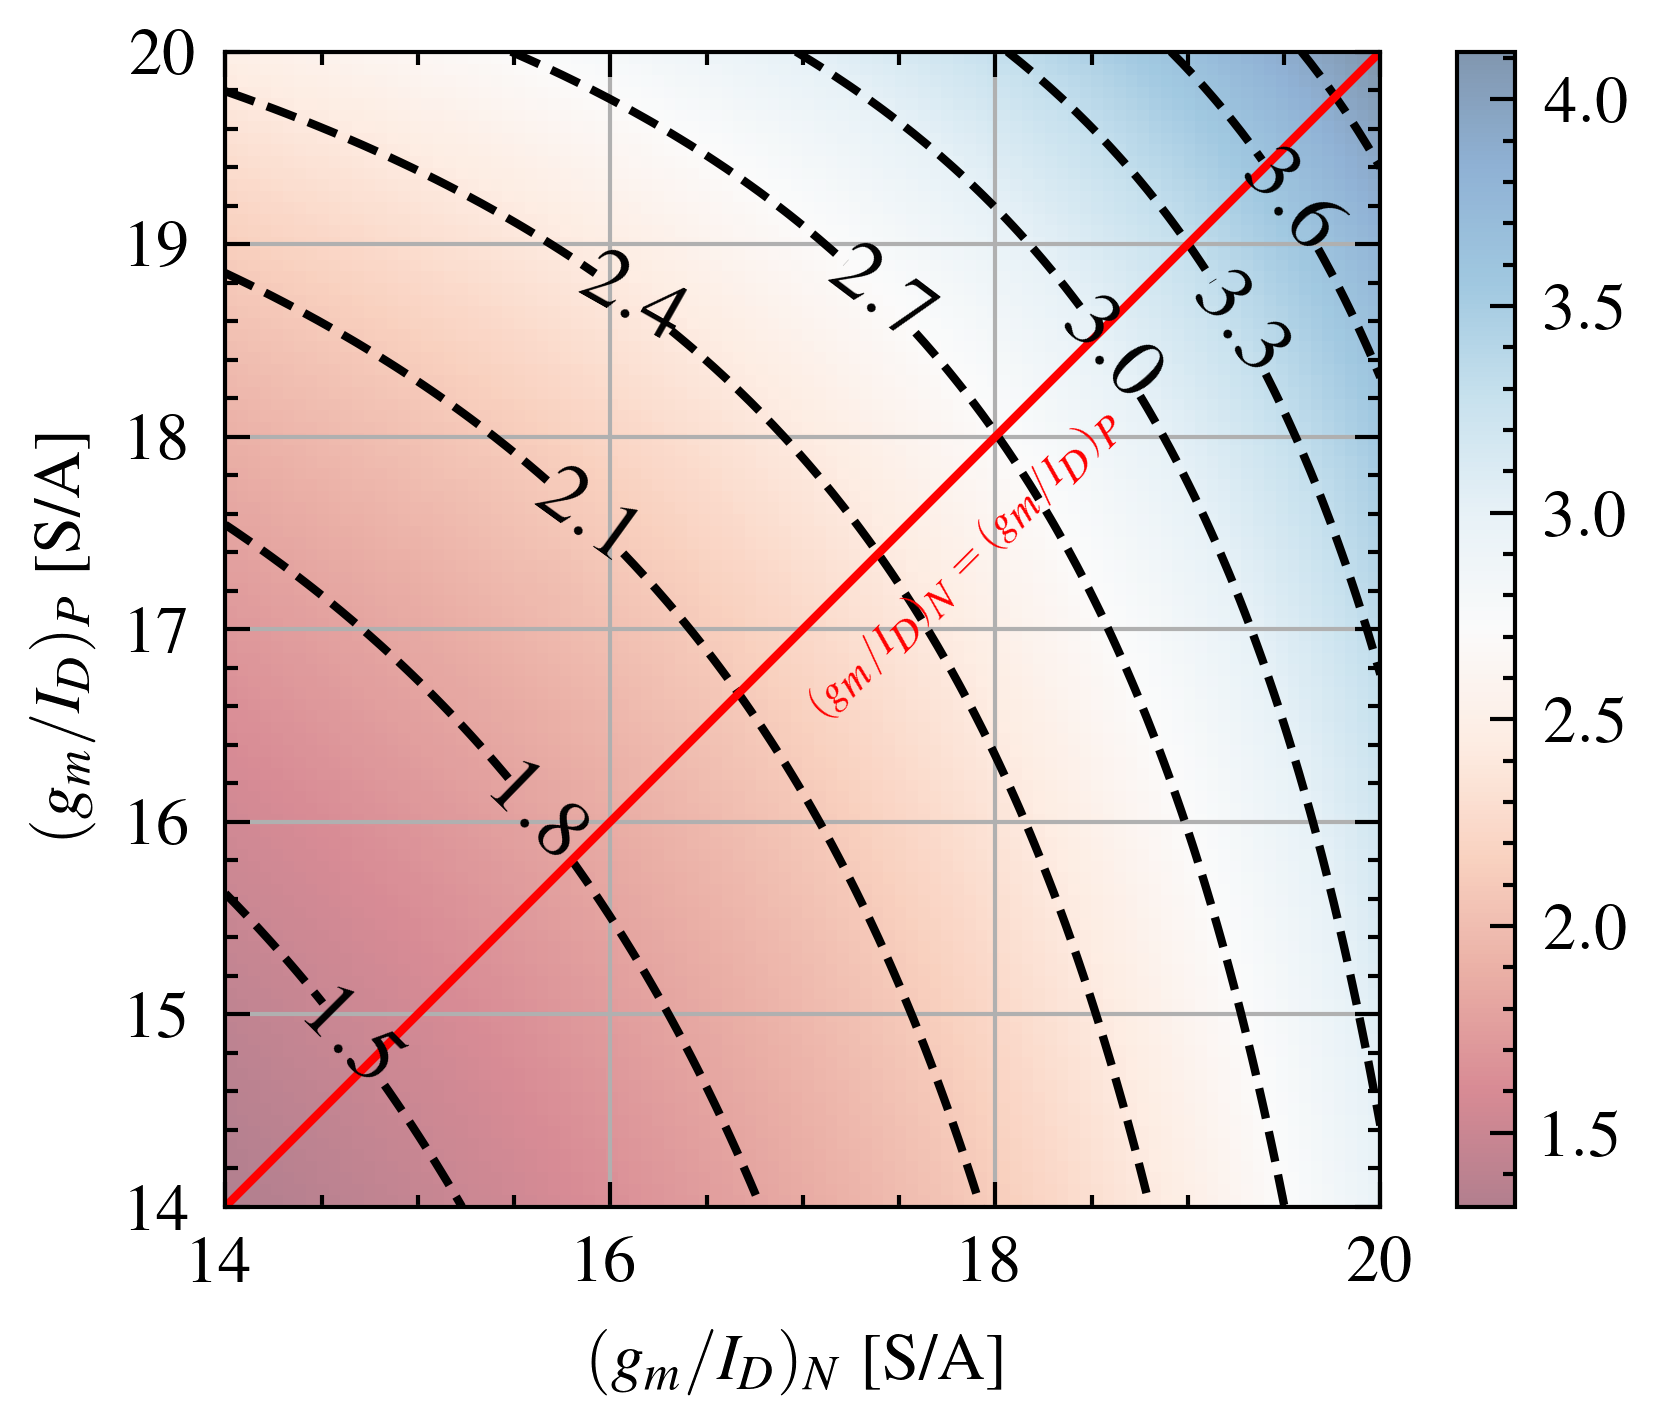

In [10]:
# plot options
c_opts = {
    'colors' : 'black',
    'linestyles' : 'dashed'
}

clabel_opts = {
    'inline' : 1,
    'fontsize' : 10,
    'colors' : 'black'
}

contour = plt.contour(GM_IDNs, GM_IDPs, 1e12 * Cgs, levels=10, **c_opts)
plt.clabel(contour, **clabel_opts)

plt.imshow(Cgs *1e12, extent=[min(GM_IDNs), max(GM_IDNs), min(GM_IDPs), max(GM_IDPs)], origin='lower',
           cmap='RdBu', alpha=0.5)

plt.colorbar()

plt.plot(GM_IDNs, GM_IDPs, color='red', linestyle="solid", linewidth=1, label='2D Line')
plt.text(17, 16.5, r"$(g_m/I_D)_N=(g_m/I_D)_P$", color='red', fontsize=5, verticalalignment='bottom',rotation=45)


#plt.title(r'Cg [pF] Vs. $(g_m/I_D)_N$ and $(g_m/I_D)_P$, $C_S$=' + f"{Cs*1e12}pF")
plt.xlabel(r"$(g_m/I_D)_N$ [S/A]")
plt.ylabel(r"$(g_m/I_D)_P$ [S/A]")
plt.grid()
plt.show()

### Compute $\overline{v_{n,in}}$

Compute $\overline{v_{n,in}}$ for fixed $C_{in}$ and fixed $I_{bias}$ against $(g_m/I_D)_P$ and $(g_m/I_D)_N$.

In [13]:
G = 20
Cs = 10e-12
colour='gray'
GM_IDPs = np.linspace(12, 24, num=100)
LP = 0.5
LN = 0.7
GM_IDNs = np.linspace(12, 24, num=100)
Ibias = 1.2e-3 / 2
VNins = np.zeros((len(GM_IDPs), len(GM_IDNs)))
Cin = 10e-12

# sweep GMID of PMOS and compute for GMID NMOS vector
VNins = amp.VNin(GM_IDNs, GM_IDPs, LN, LP, Cin=Cin, Ibias=Ibias)

C:\Users\ciano\AppData\Local\Temp\ipykernel_9700\2342207348.py:20: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection, level in zip(contour.collections, contour.levels):


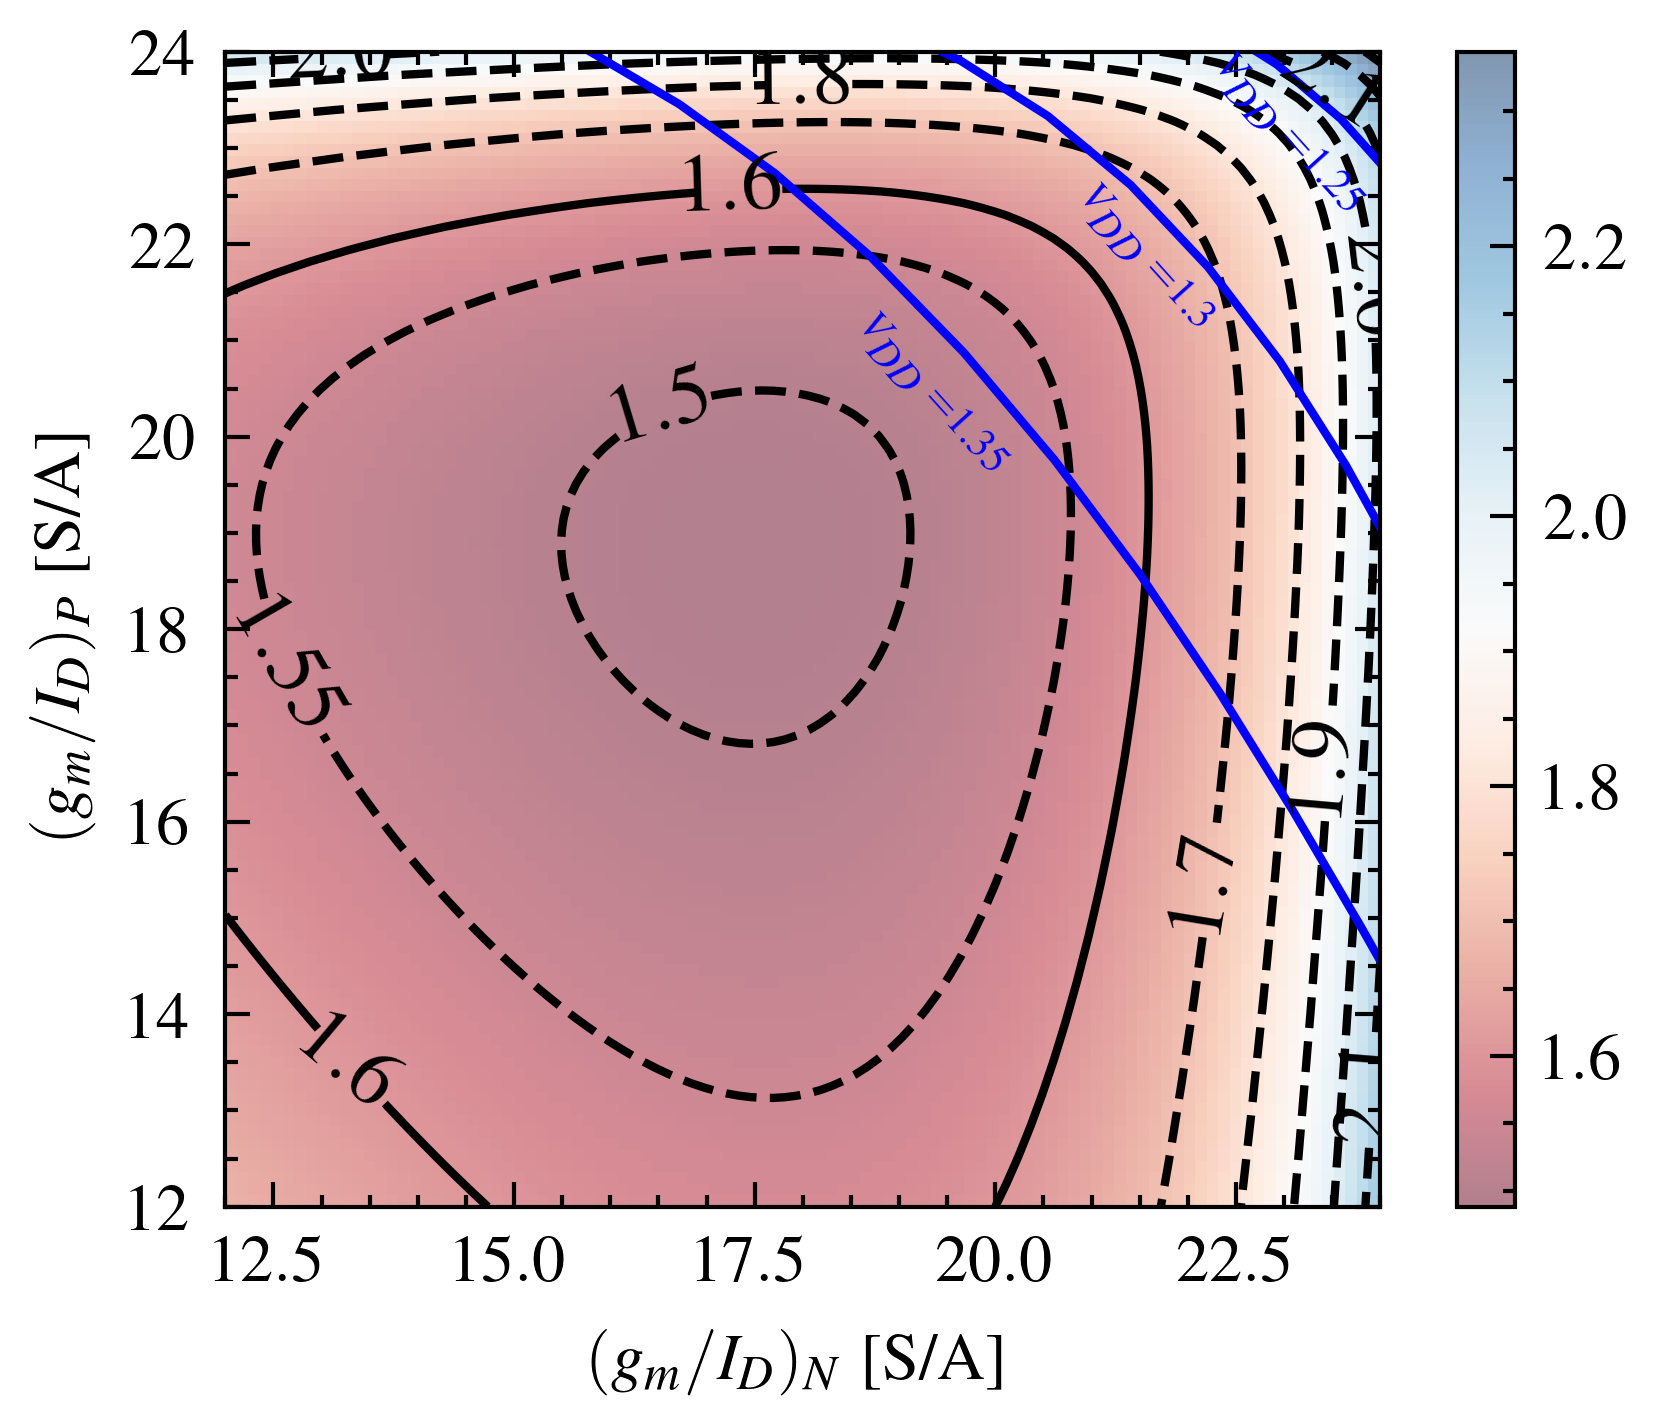

In [14]:
# plot options
c_opts = {
    'colors' : 'black',
    'linestyles' : 'dashed'
}

clabel_opts = {
    'inline' : 1,
    'fontsize' : 10,
    'colors' : 'black'
}
# scale noise to nV
VNins *= 1e9

contour = plt.contour(GM_IDNs, GM_IDPs, VNins, levels=9, **c_opts)
plt.clabel(contour, **clabel_opts)

specific_level = 0
min_level = 1.6
for collection, level in zip(contour.collections, contour.levels):
    if round(level, 1) == round(min_level, 1):
        collection.set_linestyle('solid')
        #collection.set_label("Shallow Optimum")
        
# highlight shallow optimum

specific_levels = [1.55]
specific_contour = plt.contour(GM_IDNs, GM_IDPs, VNins, levels=specific_levels, **c_opts)
plt.clabel(specific_contour, **clabel_opts)

#plt.title(r"Input Referred Noise [nV/$\sqrt{\text{Hz}}$], " + r"$C_s$=" + f"{Cs*1e12} [pF]" + "G=" + f"{G}")
plt.xlabel(r"$(g_m/I_D)_N$ [S/A]")
plt.ylabel(r"$(g_m/I_D)_P$ [S/A]")

plt.imshow(VNins, extent=[min(GM_IDNs), max(GM_IDNs), min(GM_IDPs), max(GM_IDPs)], origin='lower',
           cmap='RdBu', alpha=0.5)

coords = [(22.2,22.2),(20.8,21),(18.5,19.5)]
for coord, VDDprime in zip(coords, [1.25, 1.3, 1.35]):
    VG = np.linspace(0, VDDprime, num=100)
    VS = 0.125
    GM_IDN_PRIME = NCH.look_up("GM_ID", VGS=VG-VS, VDS=VDDprime/4)
    GM_IDP_PRIME = PCH.look_up("GM_ID", VGS=abs(VG-(VDDprime-VS)), VDS=VDDprime/4)

    plt.plot(GM_IDN_PRIME, GM_IDP_PRIME, color='blue', linestyle="solid", linewidth=1, label='2D Line')
    plt.text(coord[0], coord[1], r'$V_{DD}=$'+f"{VDDprime}", color='blue', fontsize=5, verticalalignment='bottom',rotation=-48)

plt.colorbar()
#contour_legend = plt.Line2D([0], [0], color='k', label='Shallow Optimum')
#legend = plt.legend(handles=[contour_legend],frameon=1,framealpha=1,fontsize=6)
#frame = legend.get_frame()
#frame.set_color('white')

plt.xlim(min(GM_IDNs), max(GM_IDNs))
plt.ylim(min(GM_IDPs), max(GM_IDPs))

plt.show()

### Plot $f_{1/f}$

Plot $f_{1/f}$ against $(g_m/I_D)_P$ and $(g_m/I_D)_N$

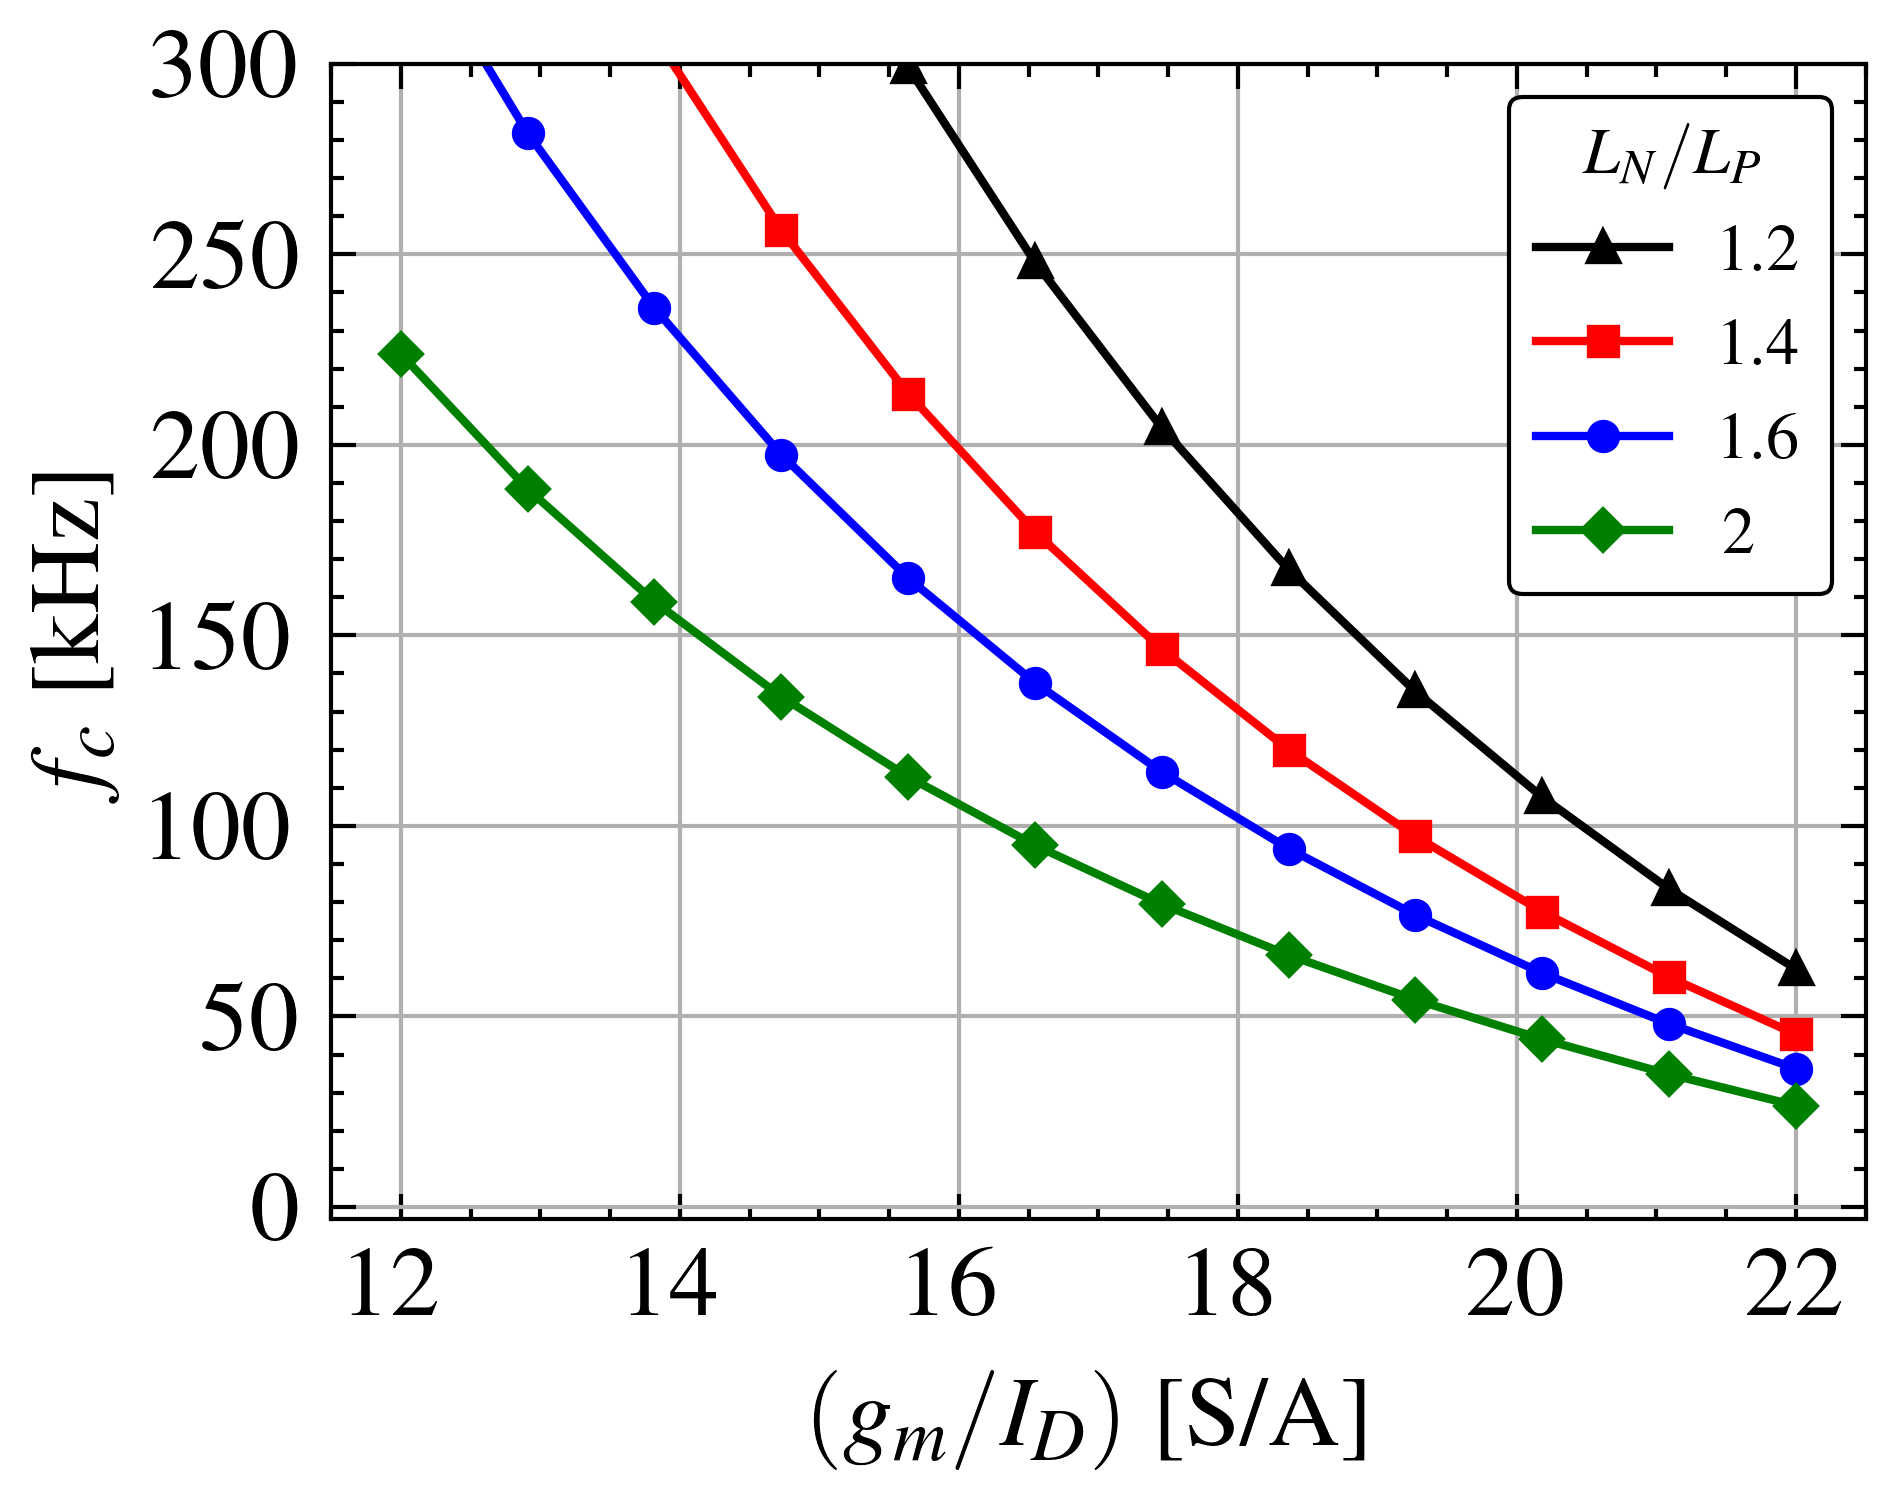

In [15]:
from cycler import cycler

fontsize = 12
# plot fco
#for Cs, colour in zip([5e-12, 10e-12, 15e-12], ['gray', 'blue', 'red']):
GM_IDNPs = np.linspace(12, 22, num=12)
LN_LPs = [ 1.2, 1.4, 1.6, 2 ]

Ibias = 1.4e-3 / 2
fcos = np.zeros((len(GM_IDPs), len(GM_IDNs)))
Cs = 10e-12

markers = ["^", "s", "o","D"]
#colors =  ["tab:blue","tab:orange","tab:green","tab:red"]

for i, LN_LP in enumerate( LN_LPs ):
    LP = 0.5
    LN = LP * LN_LP
    fcos = np.diag(amp.fco_prime(GM_IDNPs, GM_IDNPs, LN, LP))
    plt.plot(GM_IDNPs, fcos / 1e3, label=LN_LP, marker = markers[i], markersize=3, linestyle='solid')

legend = plt.legend(title=r"$L_N/L_P$",frameon=1,framealpha=1)
#legend = plt.legend(handles=[contour_legend],frameon=1,framealpha=1,fontsize=6)
frame = legend.get_frame()
frame.set_color('white')
frame.set_edgecolor('black')
frame.set_linewidth(0.5)

    #plt.clabel(contour, inline=1, fontsize=10, colors=colour)

#plt.title(r'$f_{co}$ [Hz] Vs. $(g_m/I_D)_N$ and $(g_m/I_D)_P$, $C_S$=' + f"{Cs*1e12}pF")
plt.xlabel(r"$(g_m/I_D)$ [S/A]",fontsize = fontsize)
plt.ylabel(r"$f_{c}$ [kHz]",fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.grid()
plt.ylim(top=300)
plt.show()

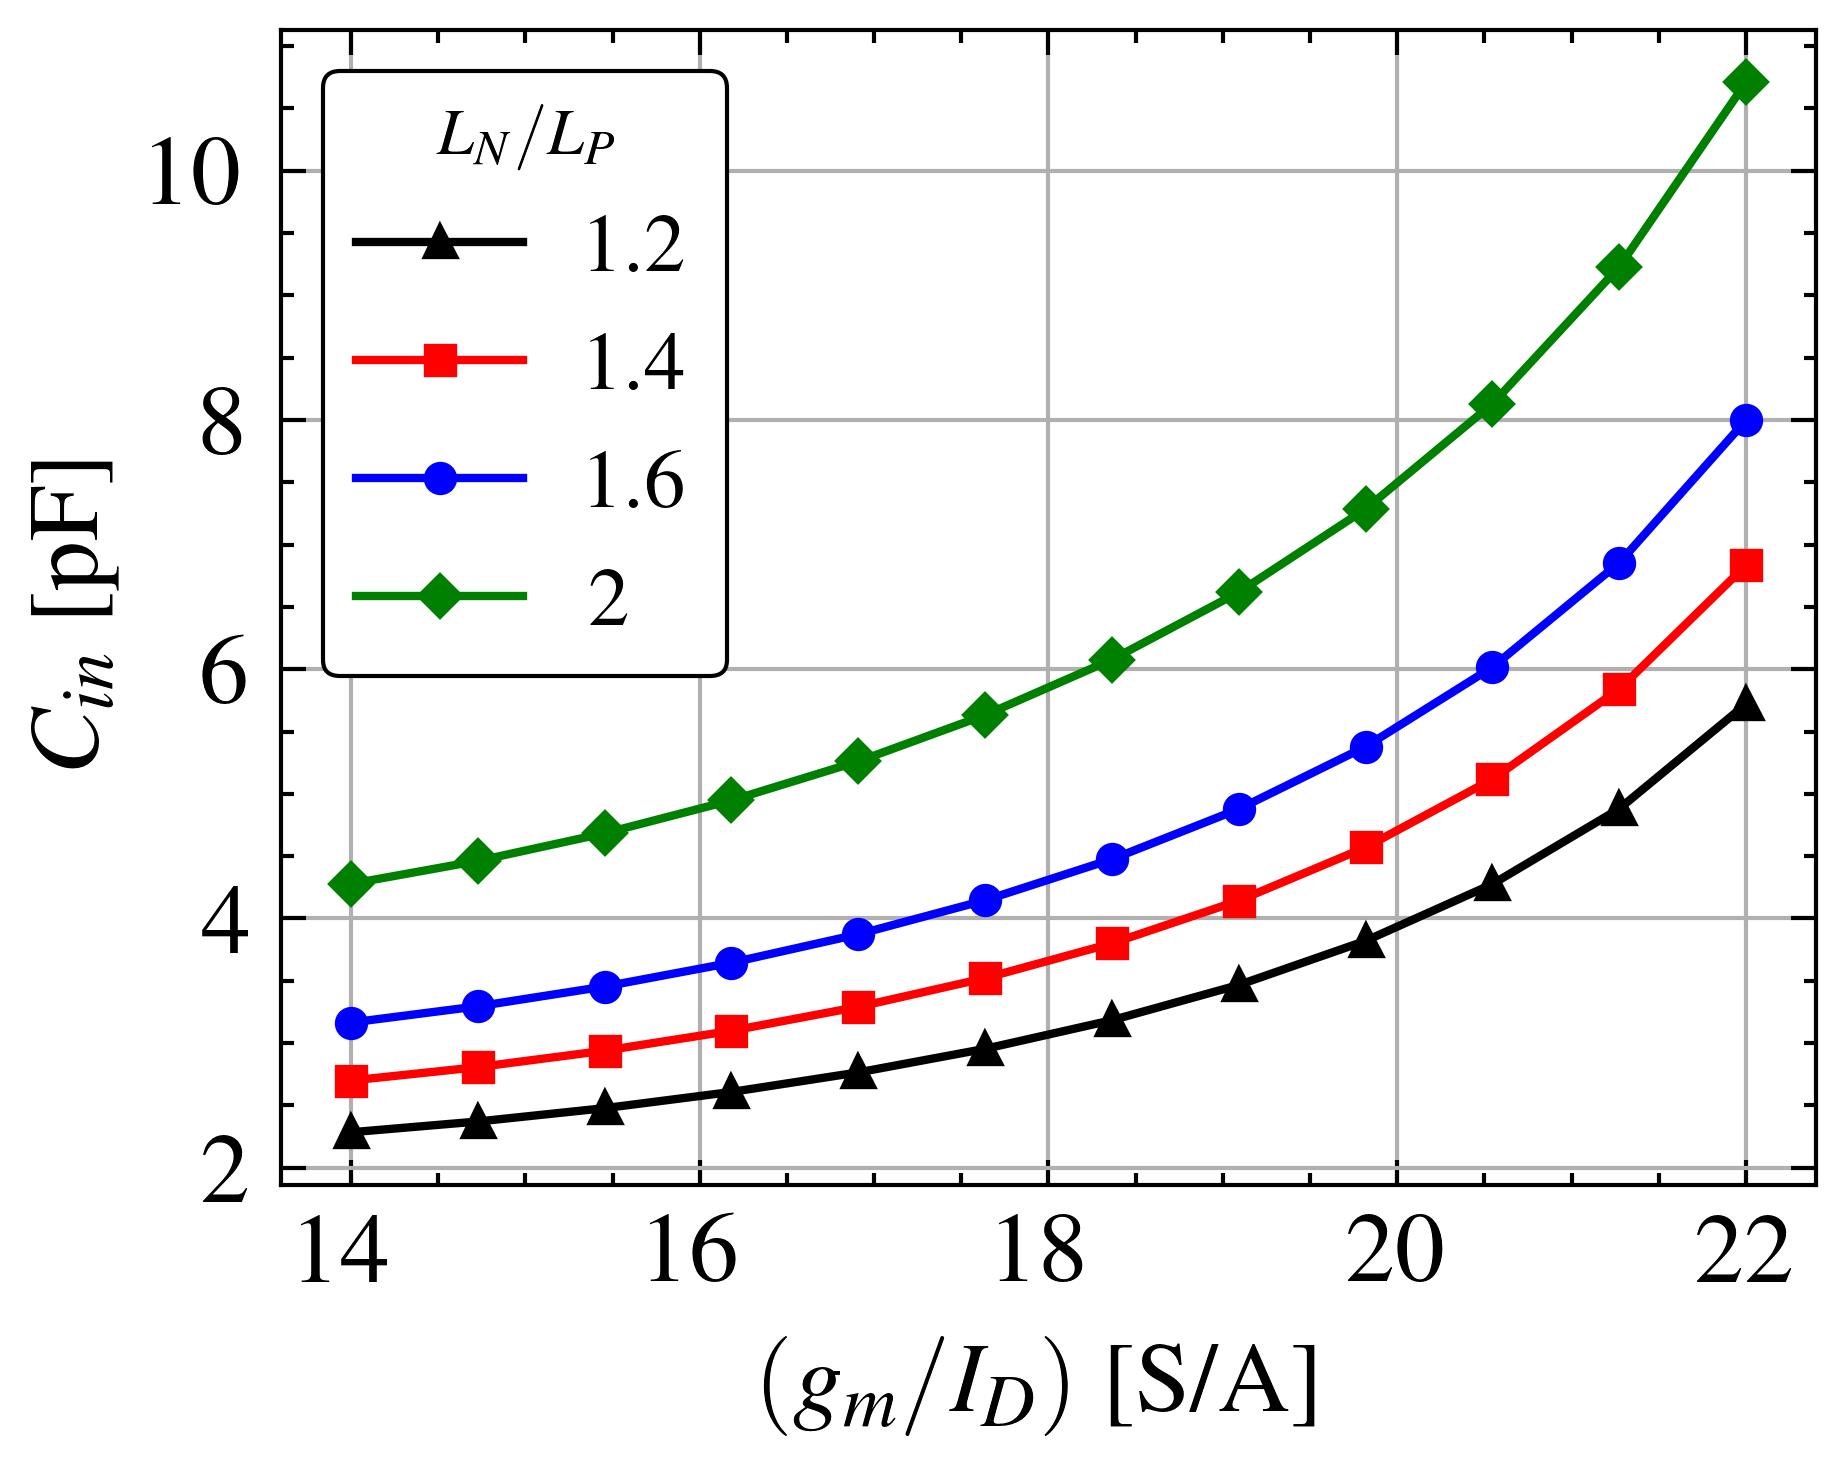

In [16]:
GM_IDNPs = np.linspace(14, 22, num=12)
LN_LPs = [ 1.2, 1.4, 1.6, 2 ]
fontsize=12
Ibias = 1.4e-3 / 2
VNinspec = 2e-9

markers = ["^", "s", "o", "D"]
#colors =  ["tab:blue","tab:orange","tab:green","tab:red"]

for i, LN_LP in enumerate( LN_LPs ):
    LP = 0.5
    LN = LP * LN_LP
    Css = np.diag(amp.Cin(GM_IDNPs, GM_IDNPs, LN, LP, Ibias=Ibias, VNin=VNinspec))
    plt.plot(GM_IDNPs, Css * 1e12, label=LN_LP, marker = markers[i], markersize=3, linestyle='solid')

legend = plt.legend(title=r"$L_N/L_P$",frameon=1,framealpha=1,fontsize=10)
frame = legend.get_frame()
frame.set_color('white')
frame.set_edgecolor('black')
frame.set_linewidth(0.5)

#plt.title(r'$f_{co}$ [Hz] Vs. $(g_m/I_D)_N$ and $(g_m/I_D)_P$, $C_S$=' + f"{Cs*1e12}pF")
plt.xlabel(r"$(g_m/I_D)$ [S/A]",fontsize=fontsize)
plt.ylabel(r"$C_{in}$ [pF]",fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.grid()
plt.show()
#########################################################################


### Fix Noise Spec and Compute Required $C_{in}$

$$
C_{in} = C_{g} / \left(\sqrt{\frac{\overline{v_{n,in}}^2\left( I_{D} \left( \left(\frac{g_m}{I_D}\right)_P + \left(\frac{g_m}{I_D}\right)_N \right) \right)}{4 k_B T \left( \gamma_P + \gamma_N \right)}} - 1/G - 1 \right)
$$

C:\Users\ciano\AppData\Local\Temp\ipykernel_9700\3725423480.py:22: UserWarning: The following kwargs were not used by contour: 'fontsize'
  contour = plt.contour(GM_IDNs, GM_IDPs, 1e12 * Css, levels=10, fontsize=fontsize, **c_opts)


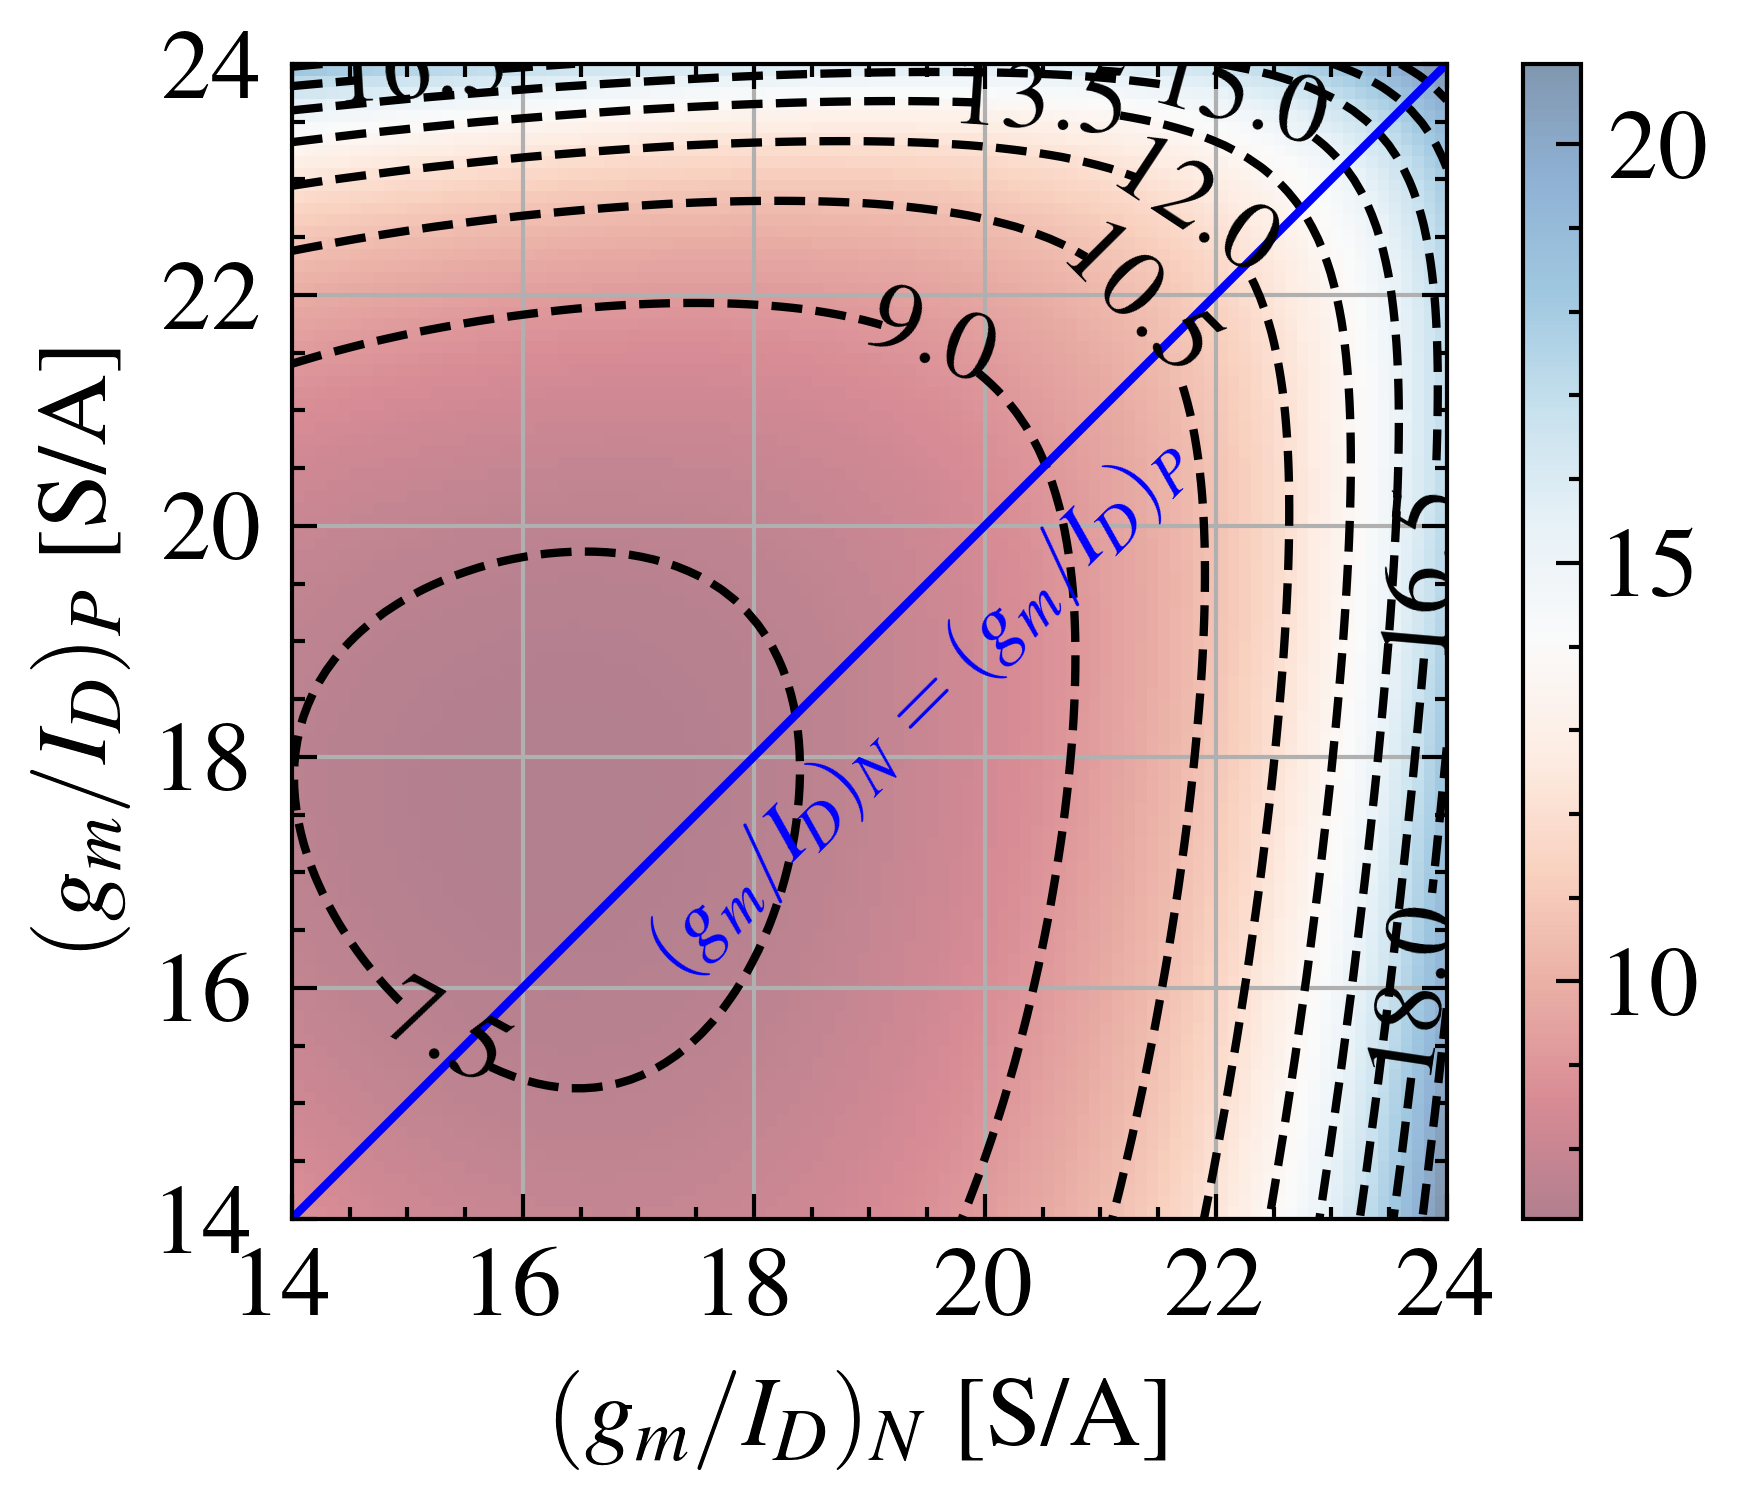

In [25]:
#for Cs, colour in zip([5e-12, 10e-12, 15e-12], ['gray', 'blue', 'red']):
GM_IDPs = np.linspace(14, 24, num=100)
LP = 0.5
LN = 0.7
GM_IDNs = np.linspace(14, 24, num=100)
Ibias = 1.2e-3 / 2
fontsize = 12
# plot options
c_opts = {
    'colors' : 'black',
    'linestyles' : 'dashed'
}

clabel_opts = {
    'inline' : 1,
    'fontsize' : fontsize,
    'colors' : 'black'
}

Css = amp.Cin(GM_IDNs, GM_IDPs, LN, LP, Ibias=Ibias, VNin=1.6e-9)

contour = plt.contour(GM_IDNs, GM_IDPs, 1e12 * Css, levels=10, fontsize=fontsize, **c_opts)
plt.clabel(contour, **clabel_opts)

#plt.title(r'$C_s$ [pF] Vs. $(g_m/I_D)_N$ and $(g_m/I_D)_P$, $\overline{V_{n,in}}\leq$' + f"{2}nV")
plt.xlabel(r"$(g_m/I_D)_N$ [S/A]",fontsize=fontsize)
plt.ylabel(r"$(g_m/I_D)_P$ [S/A]",fontsize=fontsize)

plt.imshow(Css *1e12, extent=[min(GM_IDNs), max(GM_IDNs), min(GM_IDPs), max(GM_IDPs)], origin='lower',
           cmap='RdBu', alpha=0.5)

plt.plot(GM_IDNs, GM_IDPs, color='blue', linestyle="solid", linewidth=1, label='2D Line')
plt.text(17, 16, r"$(g_m/I_D)_N=(g_m/I_D)_P$", color='blue', fontsize=10, verticalalignment='bottom',rotation=45)
plt.yticks(fontsize=fontsize)
plt.xticks(fontsize=fontsize)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=fontsize)

plt.grid()
plt.show()

### Compute $A_{v,0}$

$$
A_v = \frac{g_{m,P} + g_{m,N}}{g_{ds,P} + g_{ds,N}}
$$

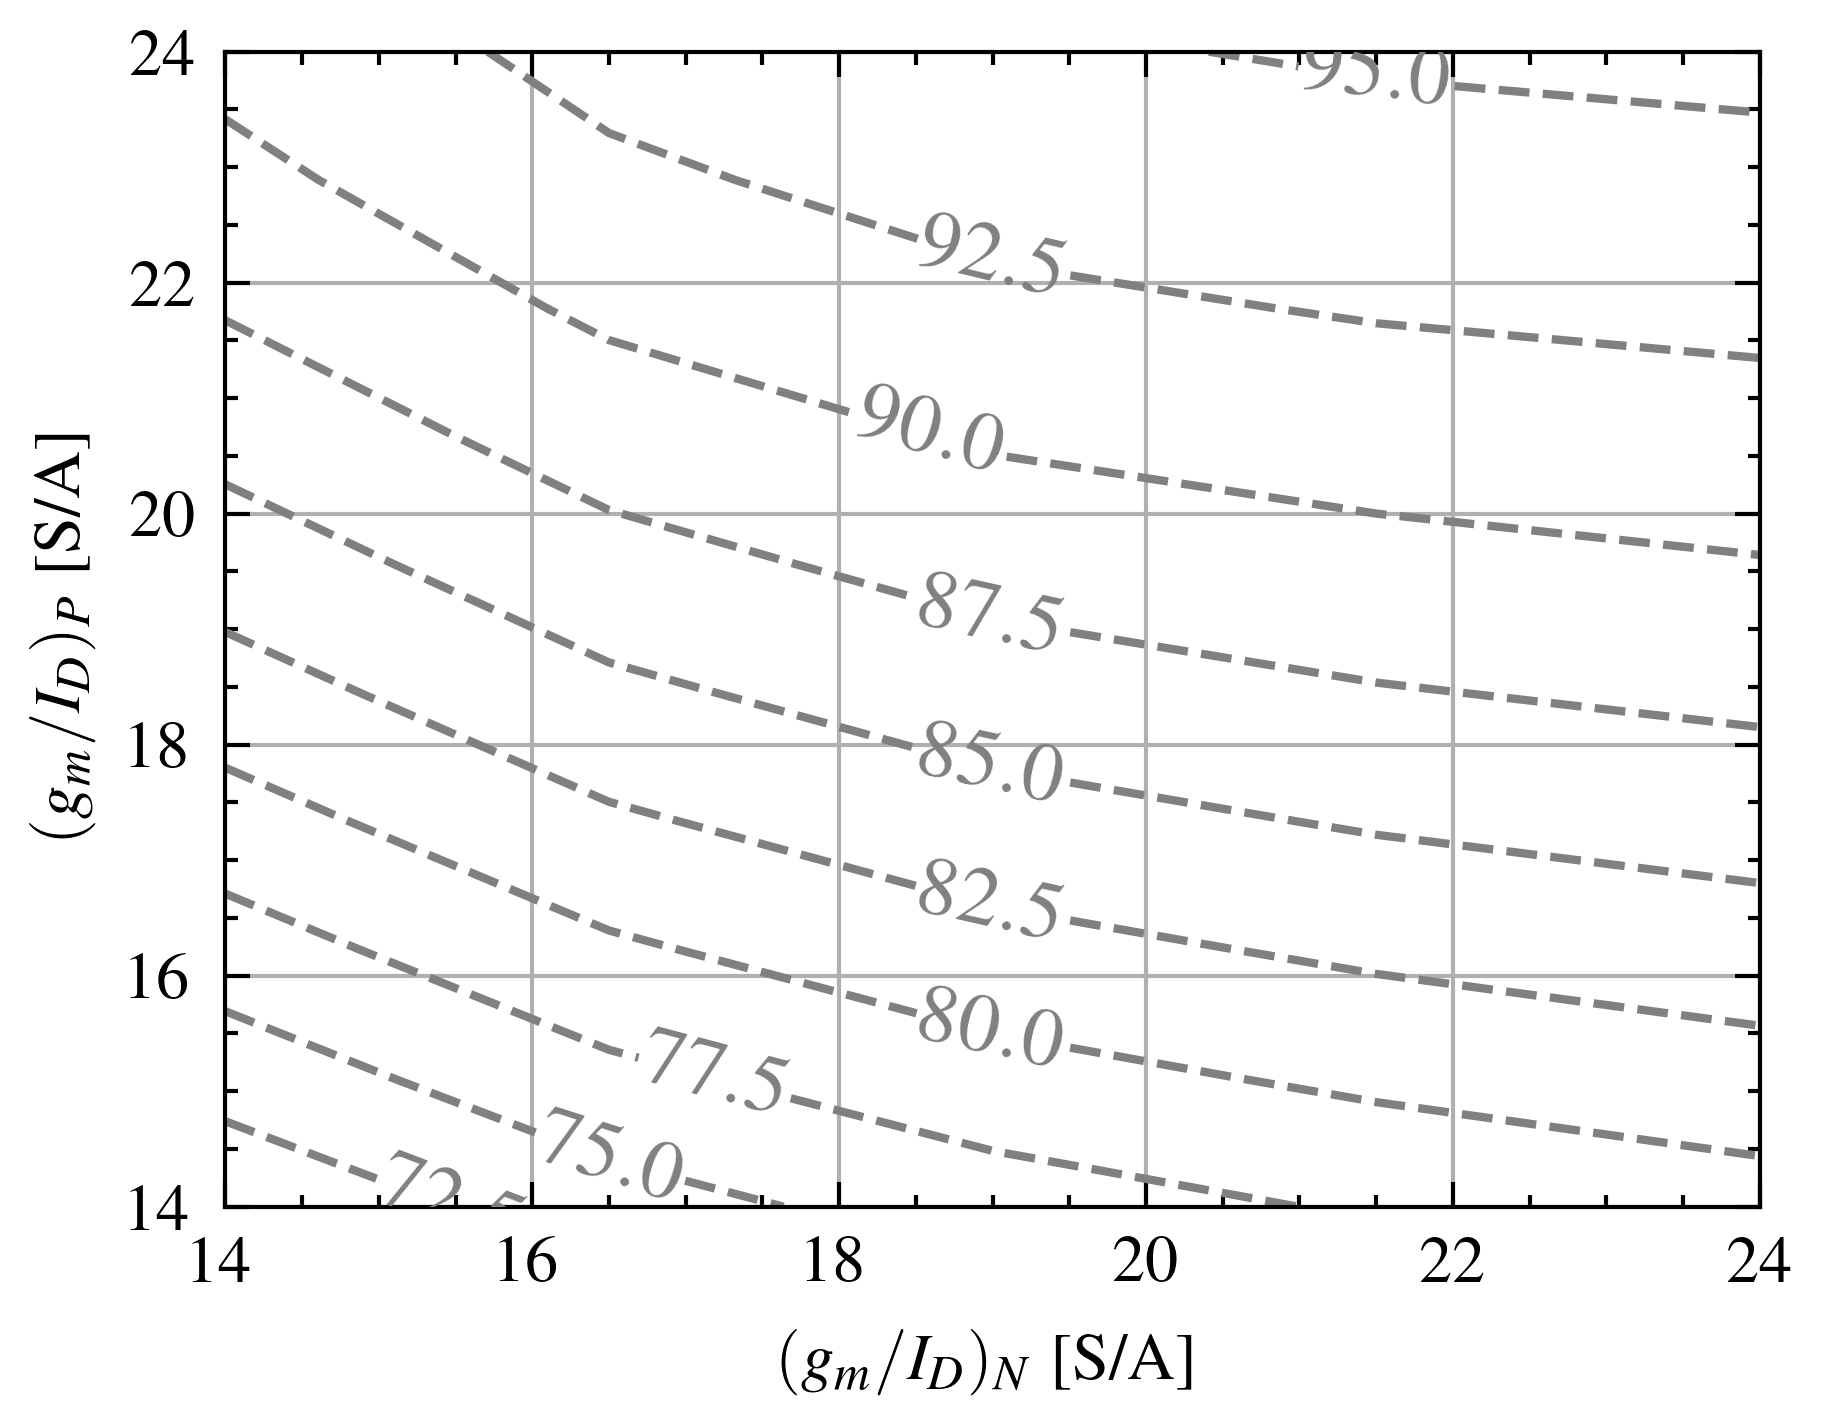

In [20]:
GM_IDPs = np.linspace(14, 24, num=10)
LP = 0.5
LN = 0.7
GM_IDNs = np.linspace(14, 24, num=5)

Av0 = amp.Av0(GM_IDNs, GM_IDPs, LN, LP)

contour = plt.contour(GM_IDNs, GM_IDPs, Av0, levels=10, colors=colour, linestyles='dashed')
plt.clabel(contour, inline=1, fontsize=10, colors=colour)

#plt.title(r'$C_s$ [pF] Vs. $(g_m/I_D)_N$ and $(g_m/I_D)_P$, $\overline{V_{n,in}}\leq$' + f"{2}nV")
plt.xlabel(r"$(g_m/I_D)_N$ [S/A]")
plt.ylabel(r"$(g_m/I_D)_P$ [S/A]")
plt.grid()
plt.show()

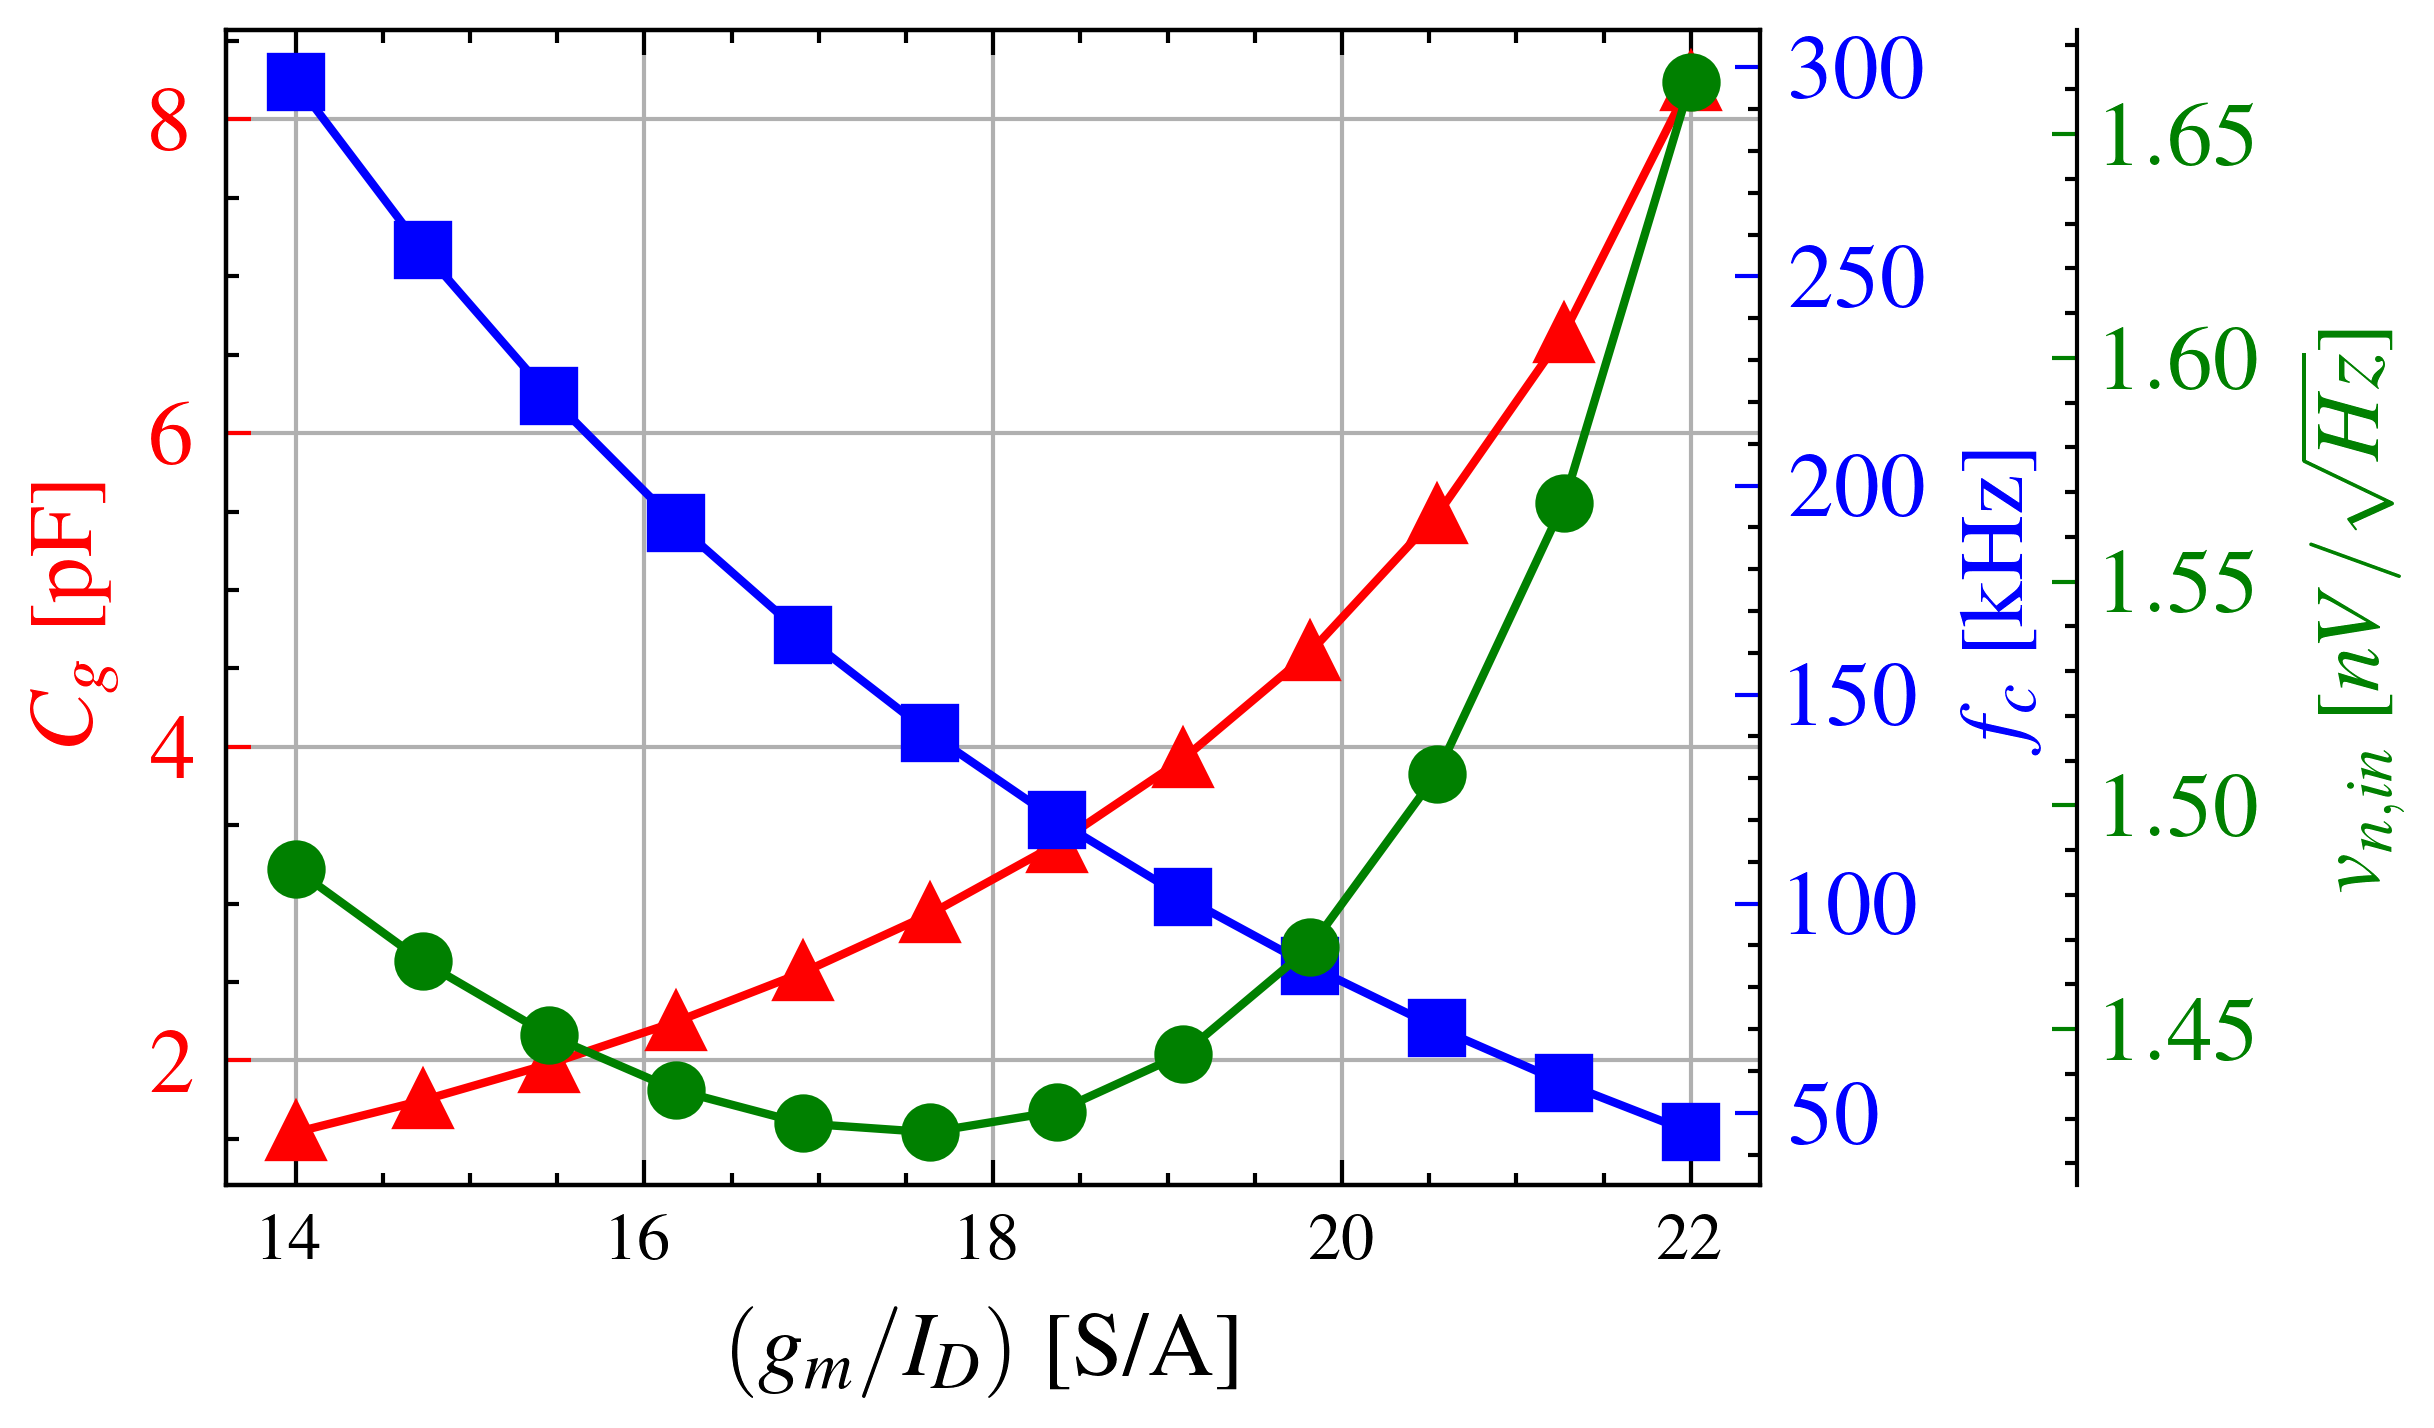

In [22]:
import matplotlib.pyplot as plt
import numpy as np
fontsize = 11
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Create the figure and the first y-axis
fig, ax1 = plt.subplots()
plt.grid()
ax1.set_xlabel(r"$(g_m/I_D)$ [S/A]",fontsize=fontsize)
ax1.set_ylabel(r"$C_{g}$ [pF]", color=colors[1],fontsize=fontsize)
ax1.plot(GM_IDNPs, Cg * 1e12, marker=markers[0], color=colors[1])

# Create the second y-axis
ax2 = ax1.twinx()  

# Plot the second dataset on the second y-axis
ax2.set_ylabel(r'$f_{c}$ [kHz]', color=colors[2],fontsize=fontsize)
ax2.plot(GM_IDNPs, fcos / 1e3, marker=markers[1], color=colors[2])

# Create the third y-axis
ax3 = ax1.twinx()

# Plot the third dataset on the third y-axis
ax3.spines['right'].set_position(('outward', 38)) # Move the spine to the right
ax3.set_ylabel(r'$v_{n,in}$ [$nV/\sqrt{Hz}$]', color=colors[3],fontsize=fontsize)
ax3.plot(GM_IDNPs, VNins * 1e9, marker=markers[2], color=colors[3])

# Adjust layout to prevent overlap
#plt.tight_layout()

ax1.tick_params(axis='y', colors=colors[1],labelsize=fontsize)
ax2.tick_params(axis='y', colors=colors[2],labelsize=fontsize)
ax3.tick_params(axis='y', colors=colors[3],labelsize=fontsize)

# Show the plot
plt.show()


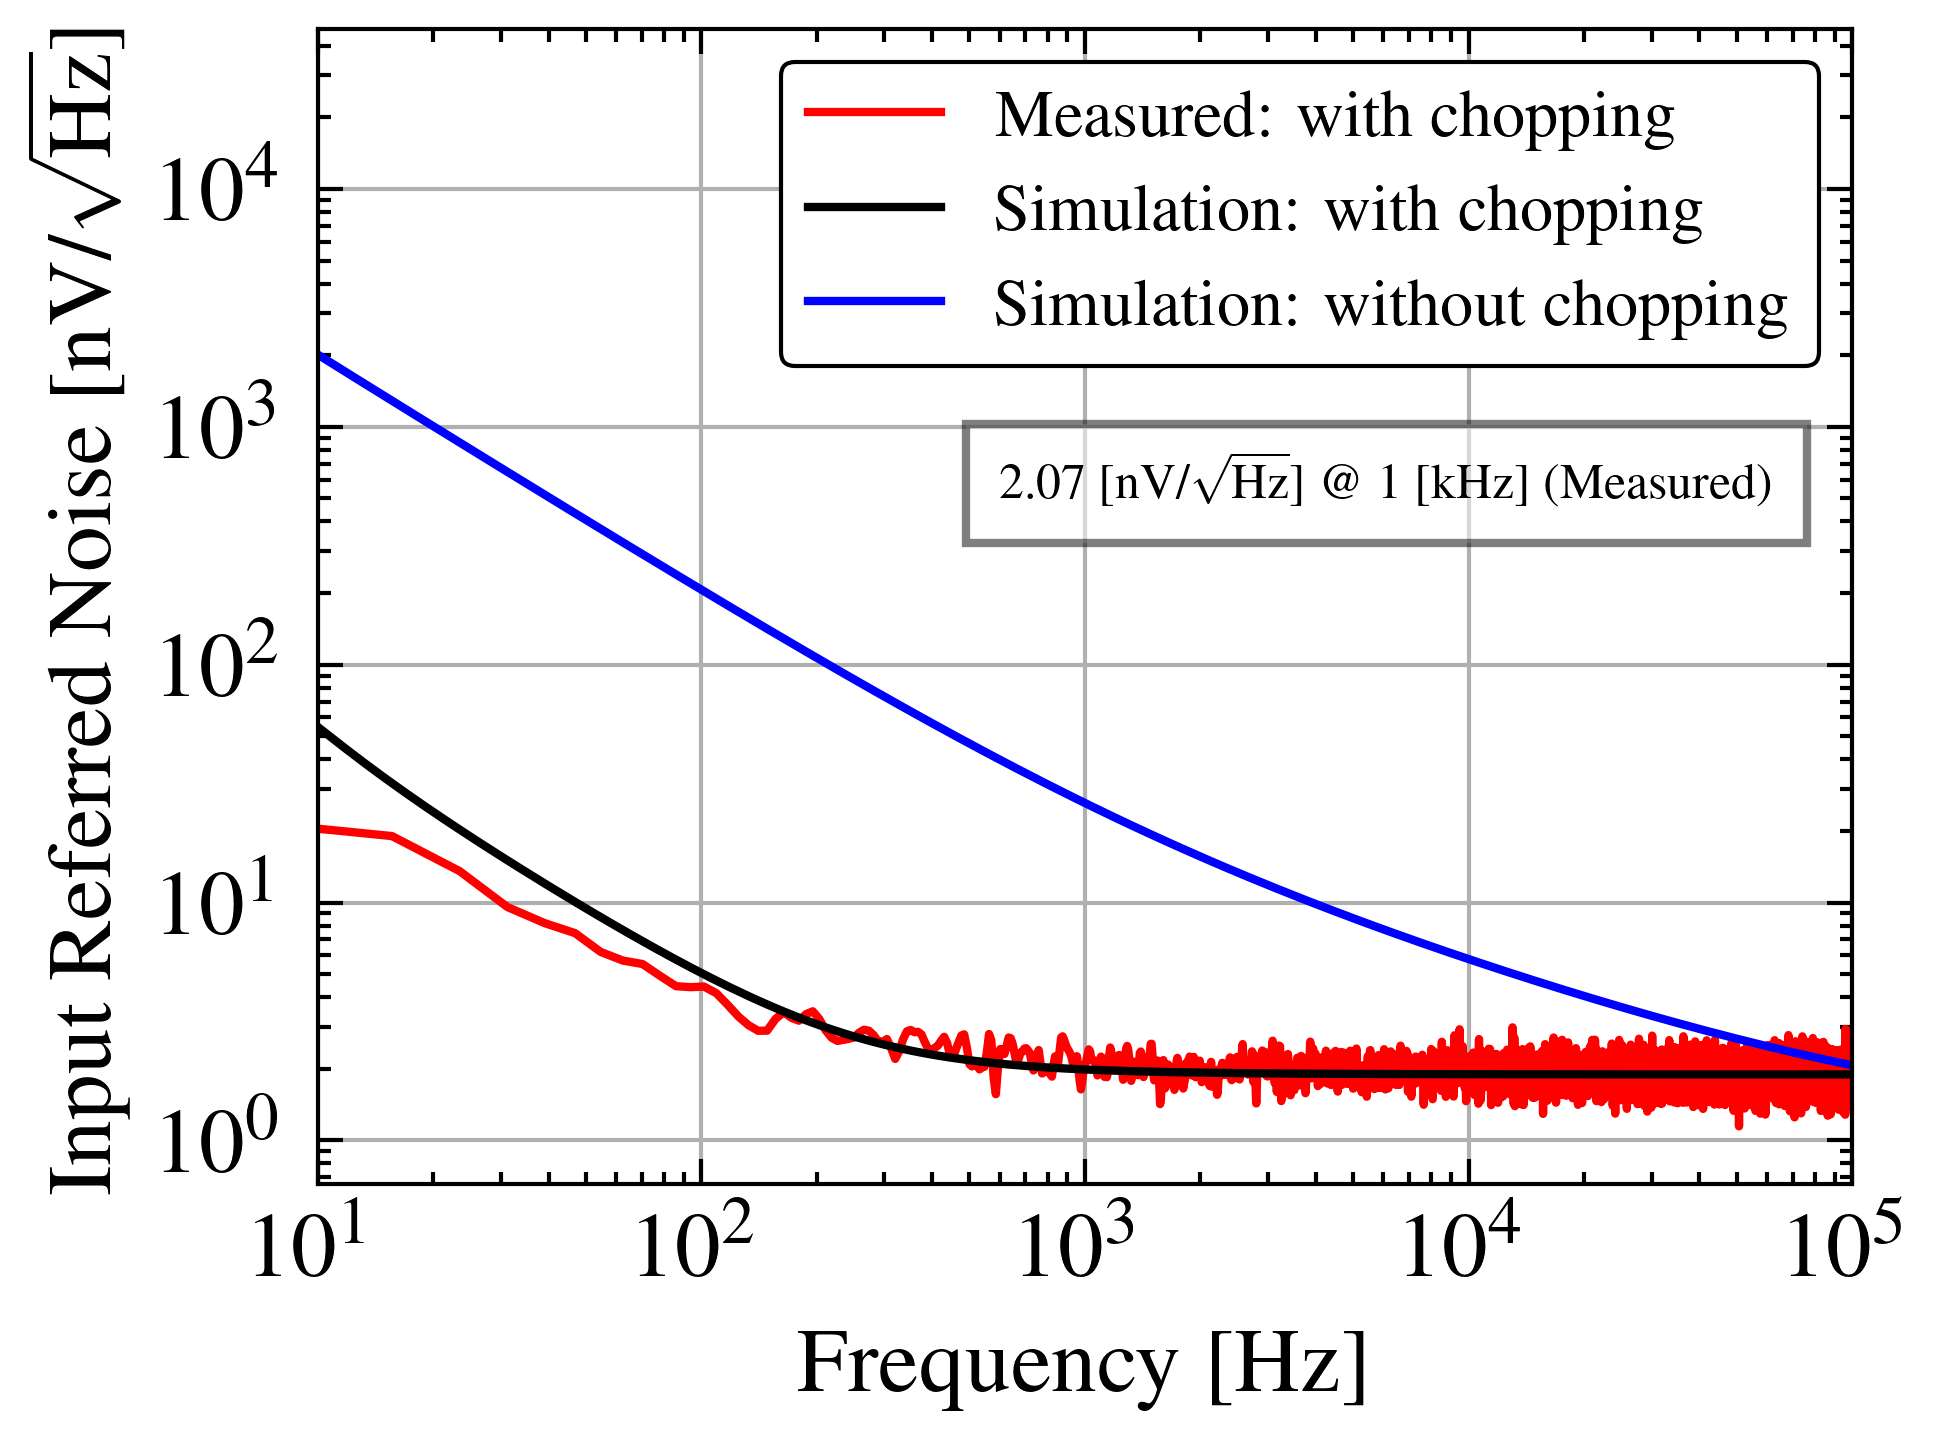

In [83]:
from scipy.io import loadmat
fontsize = 11
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

labels = ['Simulation: with chopping', 'Measured: with chopping', 'Simulation: without chopping']

# plot noise measurement data
data = loadmat('IRN_DATA.mat')
x = []
y = []
for i in range(3):
    x.append(np.array(data['xData'][0][i][0]))
    y.append(np.array(data['yData'][0][i][0]))

plt.loglog(x[1], y[1] * 1e9, label=labels[1], color=colors[1],linestyle='solid')
plt.loglog(x[0], y[0] * 1e9, label=labels[0], color=colors[0],linestyle='solid')
plt.loglog(x[2], y[2] * 1e9, label=labels[2], color=colors[2],linestyle='solid')
    
legend = plt.legend(title=r"",frameon=1,framealpha=1,fontsize=8)
frame = legend.get_frame()
frame.set_color('white')
frame.set_edgecolor('black')
frame.set_linewidth(0.5)

plt.text(0.6e3, 0.5e3, r'2.07 [nV/$\sqrt{\text{Hz}}$] @ 1 [kHz] (Measured)', fontsize=6, bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'));

#plt.title(r'$f_{co}$ [Hz] Vs. $(g_m/I_D)_N$ and $(g_m/I_D)_P$, $C_S$=' + f"{Cs*1e12}pF")
plt.xlabel(r"Frequency [Hz]",fontsize=fontsize)
plt.ylabel(r"Input Referred Noise [nV/$\sqrt{\text{Hz}}$]",fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.xlim([1e1, 1e5])
plt.grid()
plt.show()

In [ ]:
from scipy.io import loadmat
fontsize = 11
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

labels = ['Simulation: with chopping', 'Measured: with chopping', 'Simulation: without chopping']

# plot noise measurement data
data = loadmat('IRN_DATA.mat')
x = []
y = []
for i in range(3):
    x.append(np.array(data['xData'][0][i][0]))
    y.append(np.array(data['yData'][0][i][0]))

plt.loglog(x[1], y[1] * 1e9, label=labels[1], color=colors[1],linestyle='solid')
plt.loglog(x[0], y[0] * 1e9, label=labels[0], color=colors[0],linestyle='solid')
plt.loglog(x[2], y[2] * 1e9, label=labels[2], color=colors[2],linestyle='solid')
    
legend = plt.legend(title=r"",frameon=1,framealpha=1,fontsize=8)
frame = legend.get_frame()
frame.set_color('white')
frame.set_edgecolor('black')
frame.set_linewidth(0.5)

plt.text(0.6e3, 0.5e3, r'2.07 [nV/$\sqrt{\text{Hz}}$] @ 1 [kHz] (Measured)', fontsize=6, bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'));

#plt.title(r'$f_{co}$ [Hz] Vs. $(g_m/I_D)_N$ and $(g_m/I_D)_P$, $C_S$=' + f"{Cs*1e12}pF")
plt.xlabel(r"Frequency [Hz]",fontsize=fontsize)
plt.ylabel(r"Input Referred Noise [nV/$\sqrt{\text{Hz}}$]",fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.xlim([1e1, 1e5])
plt.grid()
plt.show()

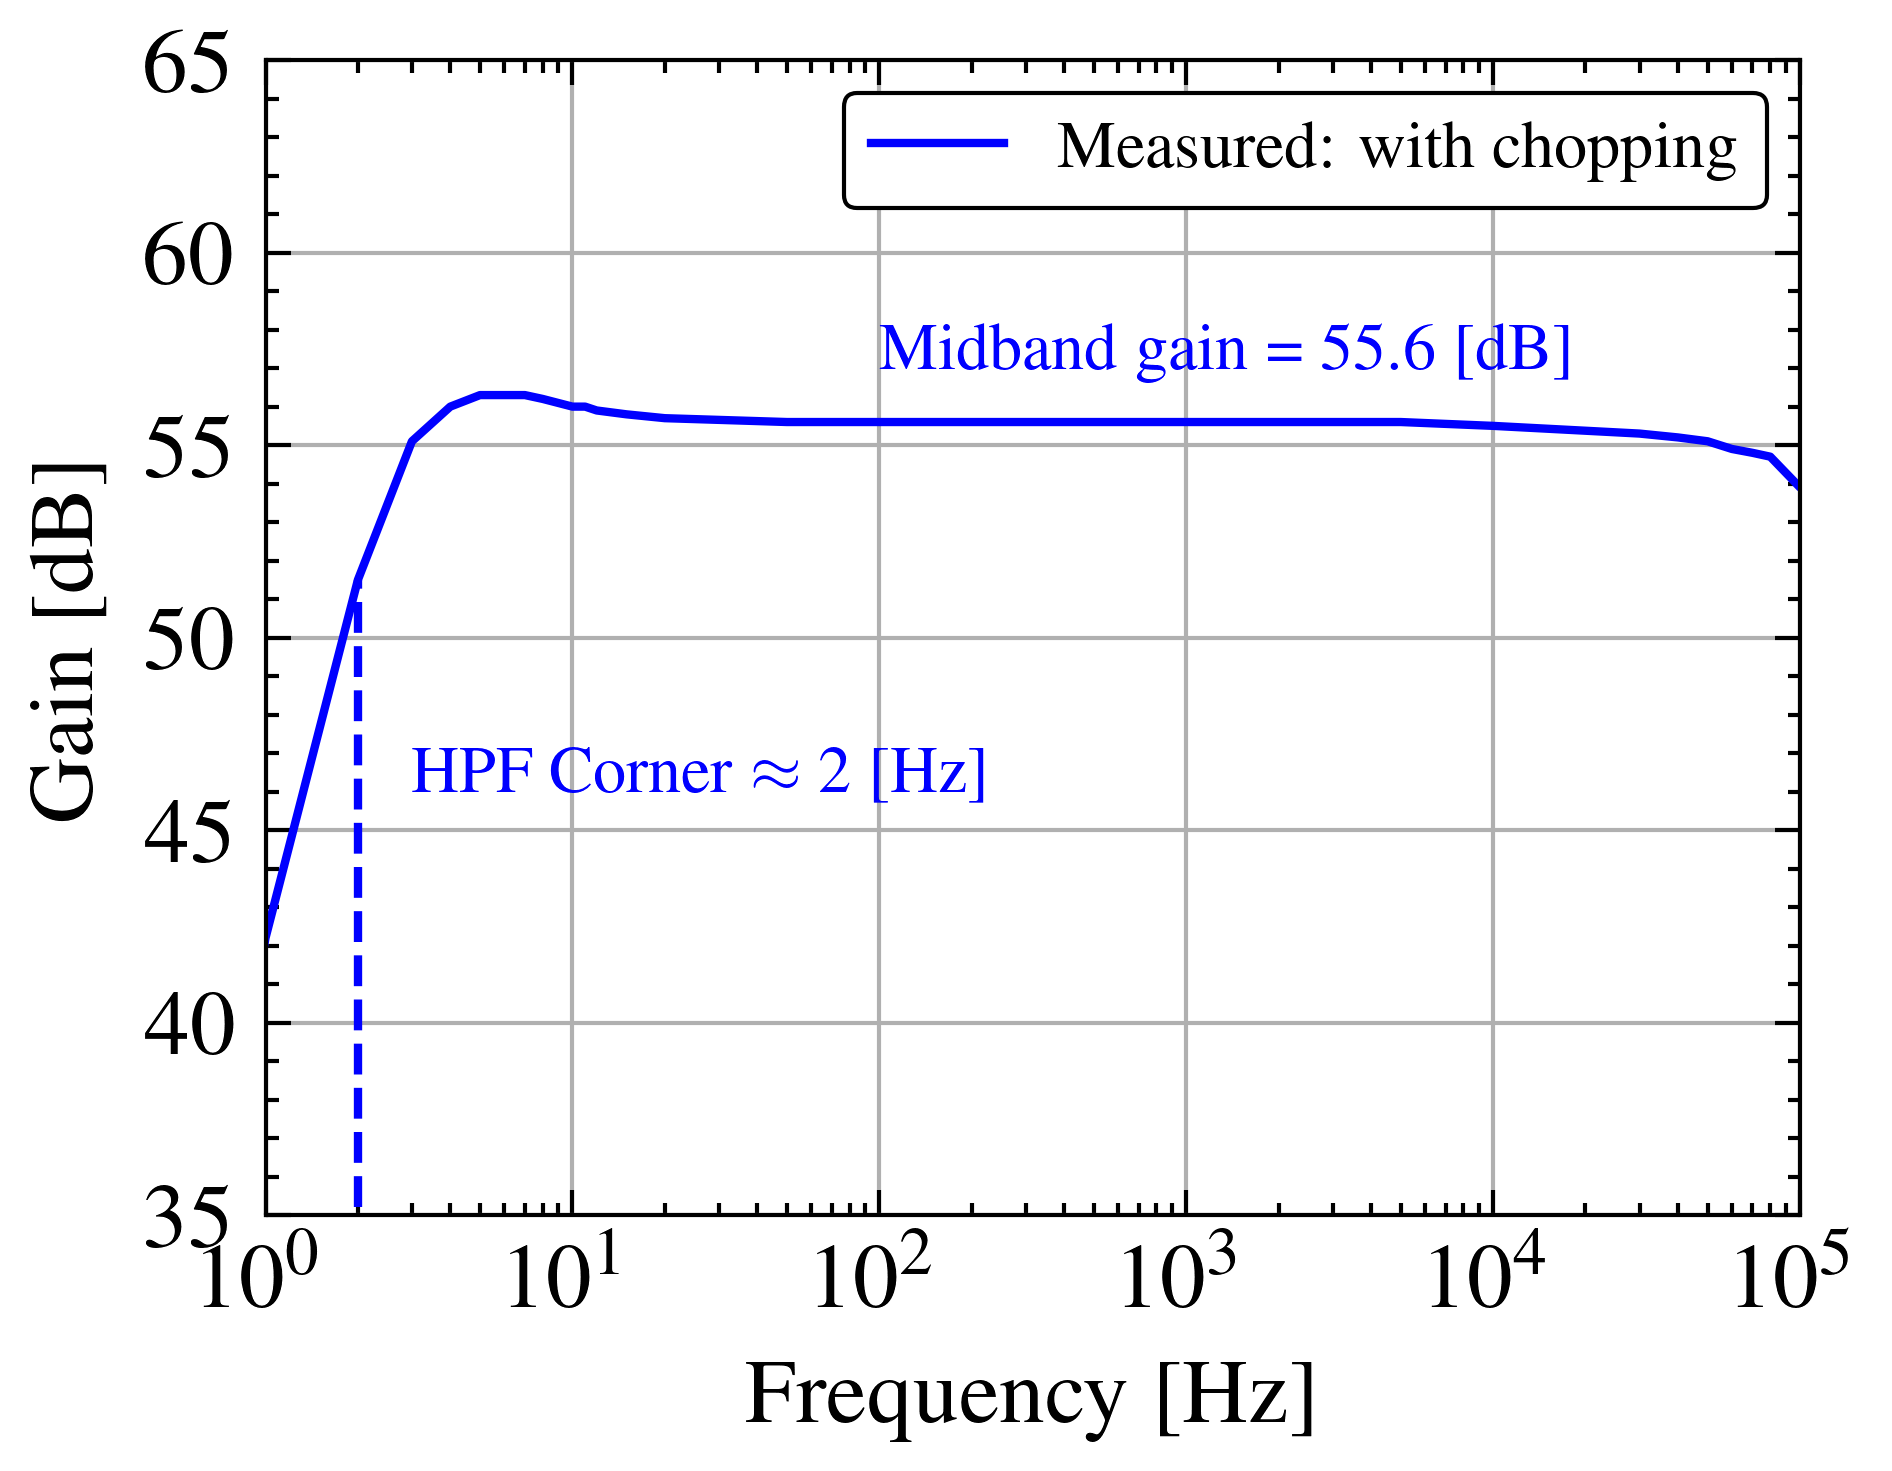

In [108]:
from scipy.io import loadmat
fontsize = 11
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

labels = ['Remove', 'Measured: with chopping']

# plot noise measurement data
data = loadmat('GAIN_DATA.mat')
x = []
y = []
for i in range(2):
    x.append(np.array(data['xData'][0][i][0]))
    y.append(np.array(data['yData'][0][i][0]))

plt.semilogx(x[1], y[1], label=labels[1], color=colors[2],linestyle='solid')
#plt.loglog(x[0], y[0] * 1e9, label=labels[0], color=colors[0],linestyle='solid')
    
legend = plt.legend(title=r"",frameon=1,framealpha=1,fontsize=8)
frame = legend.get_frame()
frame.set_color('white')
frame.set_edgecolor('black')
frame.set_linewidth(0.5)

#plt.text(0.6e3, 0.5e3, r'2.07 [nV/$\sqrt{\text{Hz}}$] @ 1 [kHz] (Measured)', fontsize=6, bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'));

plt.text(1e2, 57, r'Midband gain = 55.6 [dB]', color=colors[2], fontsize=8, bbox=dict(facecolor='white', alpha=0));
plt.text(3, 46, r'HPF Corner $\approx$ 2 [Hz]', color=colors[2], fontsize=8, bbox=dict(facecolor='white', alpha=0));


#plt.title(r'$f_{co}$ [Hz] Vs. $(g_m/I_D)_N$ and $(g_m/I_D)_P$, $C_S$=' + f"{Cs*1e12}pF")
plt.xlabel(r"Frequency [Hz]",fontsize=fontsize)
plt.ylabel(r"Gain [dB]",fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.xlim([1e0, 1e5])
plt.ylim([35, 65])
plt.vlines(2,ymin=0,ymax=51.5,linestyle='dashed',color=colors[2])
plt.grid()
plt.show()